# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [1]:
# from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import zstandard

pd.set_option('display.max_columns', None)

**Read data file**

In [2]:
%mkdir "Patient_Data"

Ein Unterverzeichnis oder eine Datei mit dem Namen "Patient_Data" existiert bereits.


In [3]:
dctx = zstandard.ZstdDecompressor()
with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
    dctx.copy_stream(ifh, ofh)
my_tar = tarfile.open('training.tar')
my_tar.extractall('Patient_Data') # specify which folder to extract to
my_tar.close()
%cd "Patient_Data/training/training_setA/"

C:\Users\dorot\sepsis\Patient_Data\training\training_setA


In [4]:
# load all data sets (roughly 20000 for set A)
wd = Path(".")
full_df_from_disk = list(pd.read_csv(f, sep = "|") for f in wd.glob("p0*.psv"))
full_df = pd.concat(full_df_from_disk)

## Preprocess Data File

In [5]:
full_df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0


In [6]:
full_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

As you can see, we have a total of 41 endpoints. You can find a description of those here: 
https://physionet.org/content/challenge-2019/1.0.0/#objective

**Reset index, creating time variable**

In [7]:
def add_patient_id_and_idx(df):
  # Reset index, creating time variable
  df = df.reset_index(names=["time"])
  # Add patient id variable
  groups_by_patient = df['time'].diff().lt(0)
  groups_by_sepsis_label = df['SepsisLabel'].diff().abs().gt(0)
  result = pd.concat([groups_by_patient, groups_by_sepsis_label], axis=1)
  groups = result.any(axis=1)
  df['patient_id'] = groups_by_patient.cumsum()

  return df

In [8]:
full_df = add_patient_id_and_idx(full_df)

In [9]:
display(full_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,28,88.0,98.0,NaN,135.0,81.00,64.0,16.0,NaN,NaN,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,31,1,20335
790211,29,96.0,98.0,38.72,174.0,97.00,72.0,16.0,NaN,2.0,NaN,NaN,7.48,34.0,97.0,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,32,1,20335
790212,30,140.0,97.0,NaN,133.0,81.50,62.5,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,33,1,20335
790213,31,120.0,96.0,NaN,154.0,118.00,105.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,34,1,20335


Optional: save as csv

In [10]:
# full_df.to_csv("/tmp/sepsis/training_setA.csv", index=False)

## Exploratory Data Analysis

### Single and Subsample Analysis

You can use the following cells to visualize the timeline of single patients.

In [11]:
first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

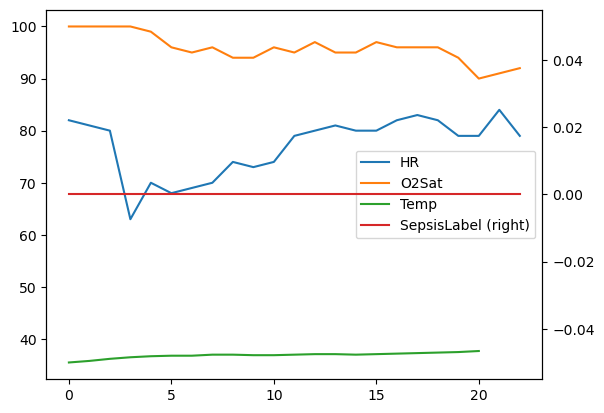

In [12]:
ax = first_patient_df[["HR", "O2Sat", "Temp"]].plot()
first_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

Subsample (first n samples). We see that we will have to deal with a lot of heterogeneity.

In [13]:
# load the first 10 data sets
wd = Path(".")
sample_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
sample_df = pd.concat(sample_df)

<Axes: >

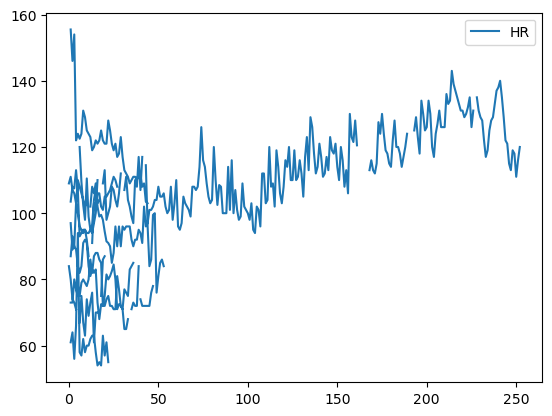

In [14]:
sample_df[["HR"]].plot()

39.6956956956957 mean total hours time in the ICU


Text(0.5, 0, 'ICULOS (days)')

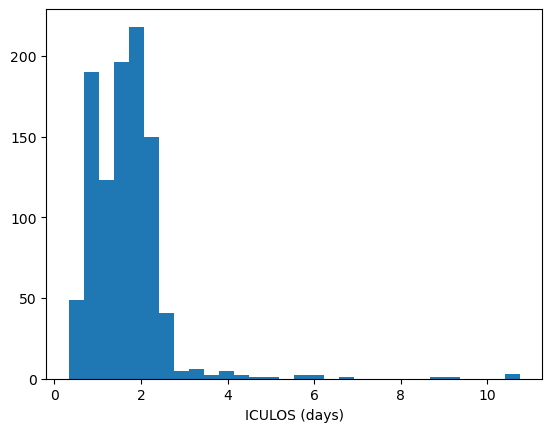

In [15]:
# load the first 1000 data sets
# what is the mean total time in the ICU (ICULOS)?
# ICULOS = intensive care unit length of stay
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
ICULOS_times = np.array([])
for df in big_df:
  ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
plt.hist(ICULOS_times/24, bins=30)
plt.xlabel('ICULOS (days)')

### Full Sample Analysis

Number of patients in total and patients with sepsis

In [16]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")



Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

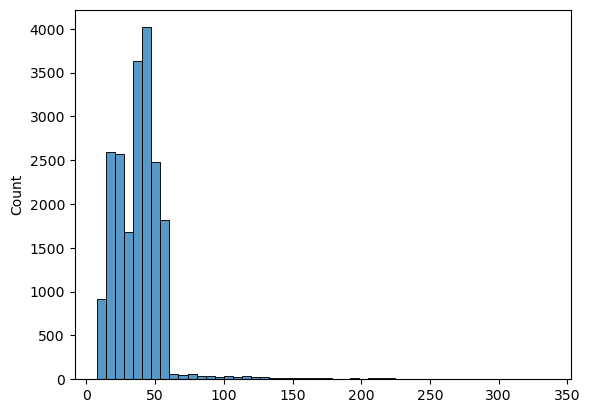

In [17]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

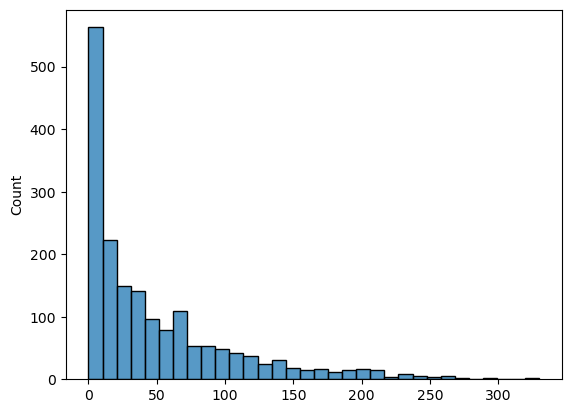

In [18]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])

sns.histplot(sepsis_time, kde=False);


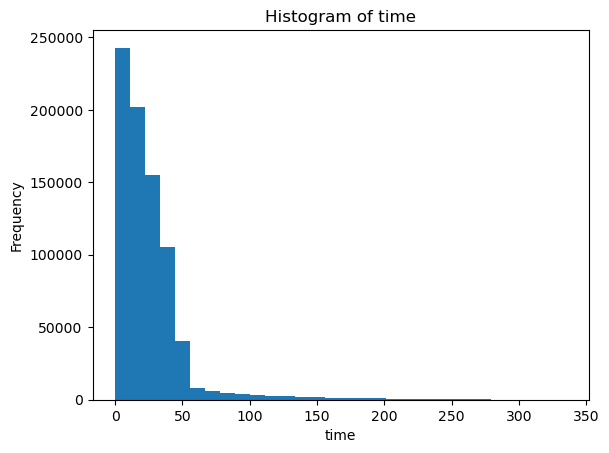

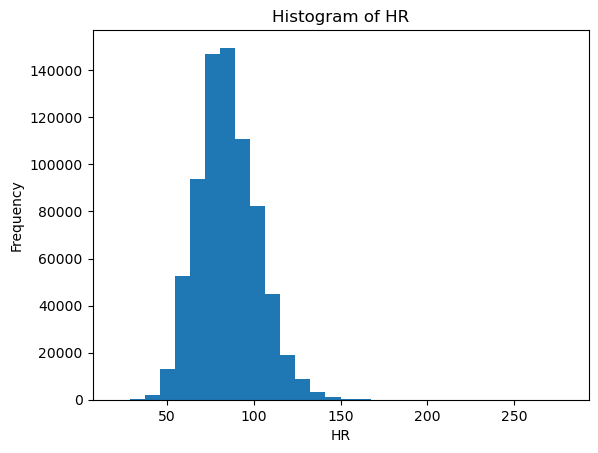

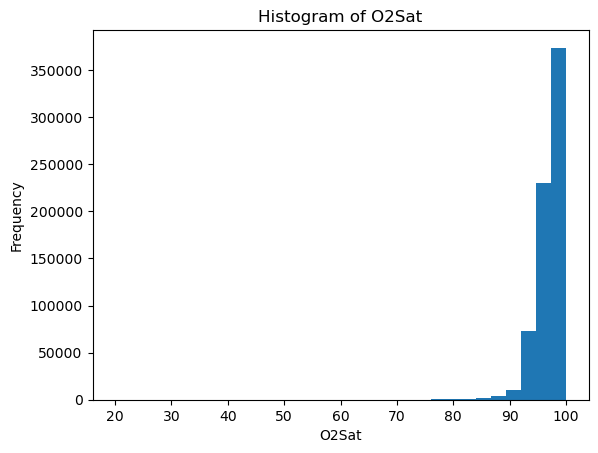

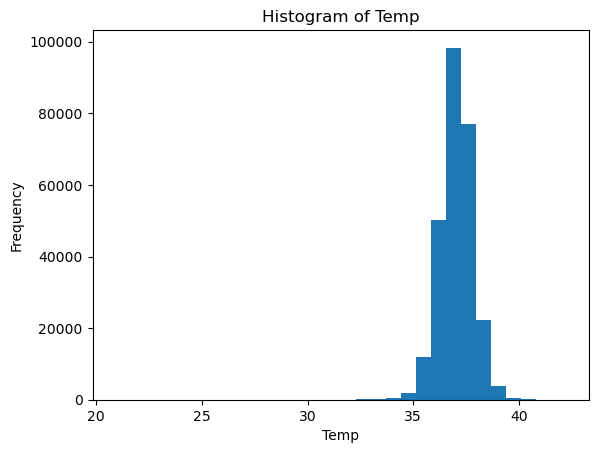

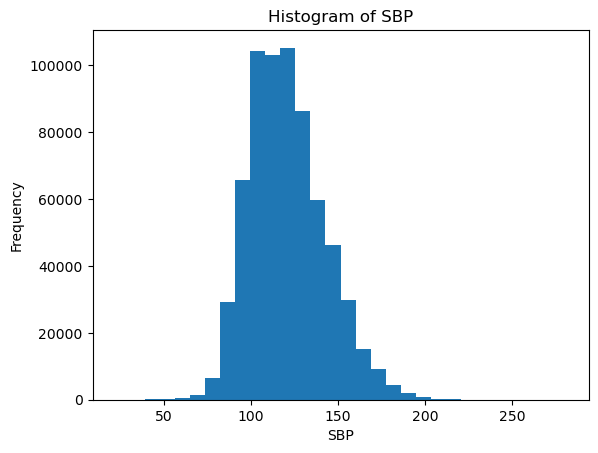

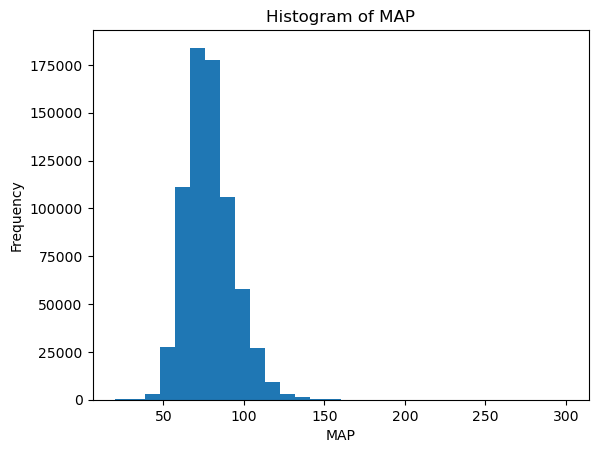

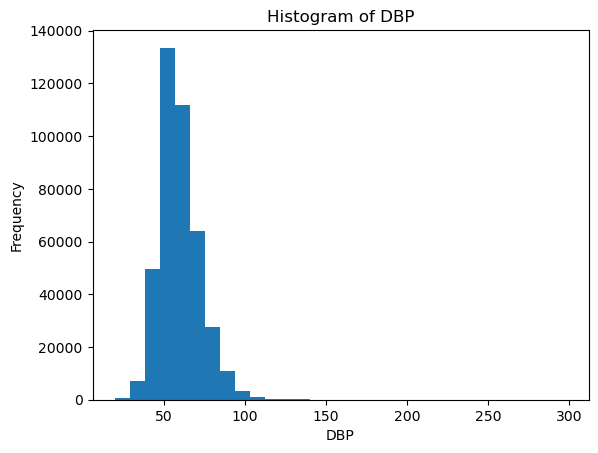

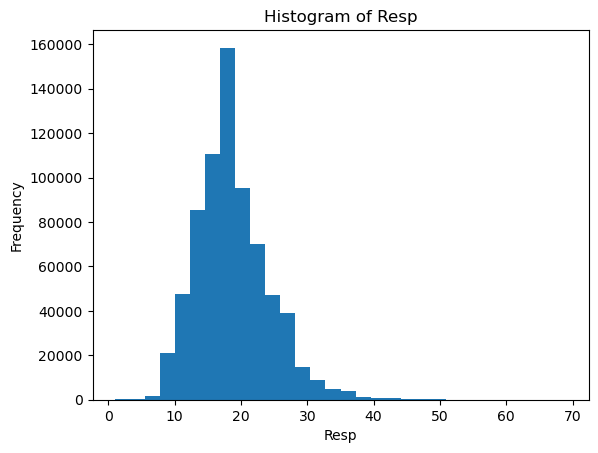

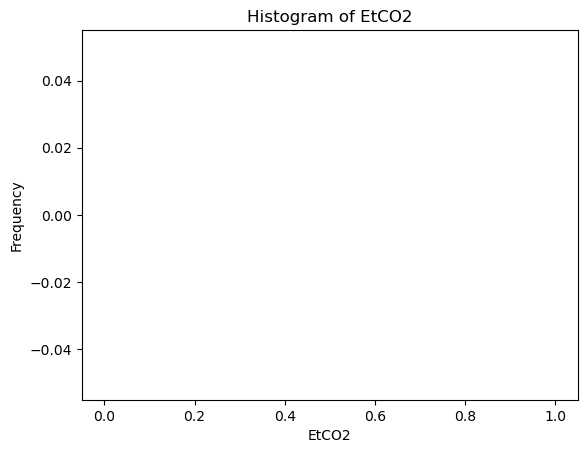

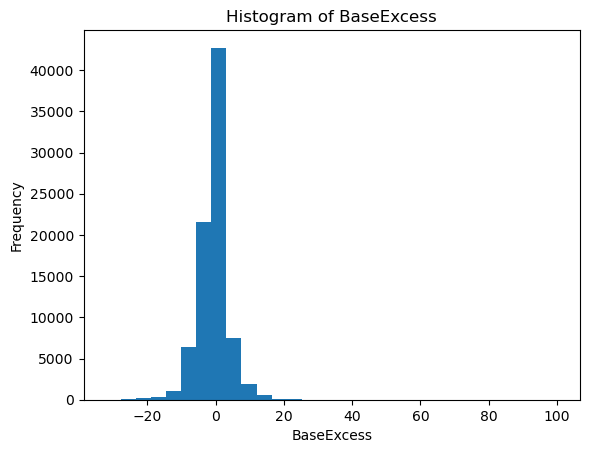

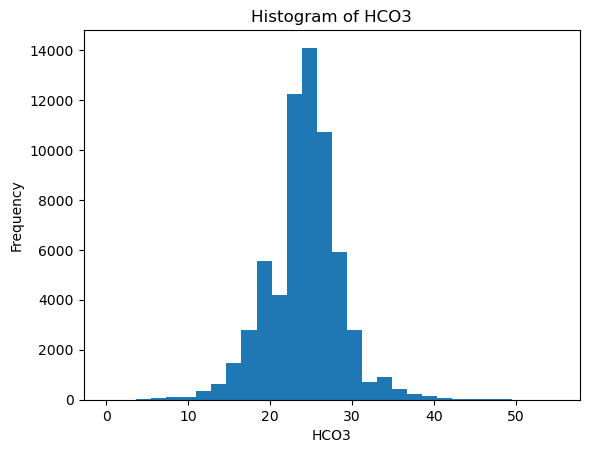

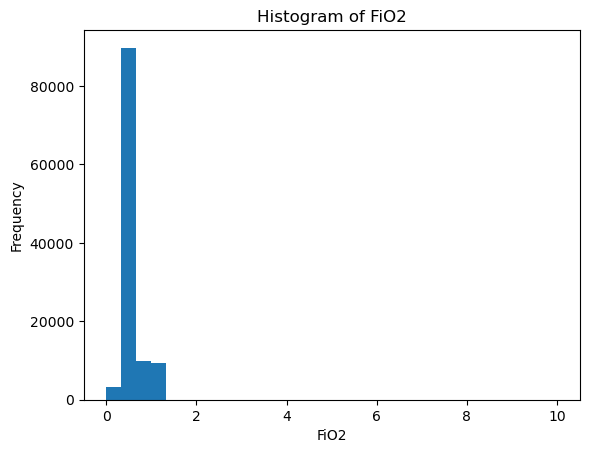

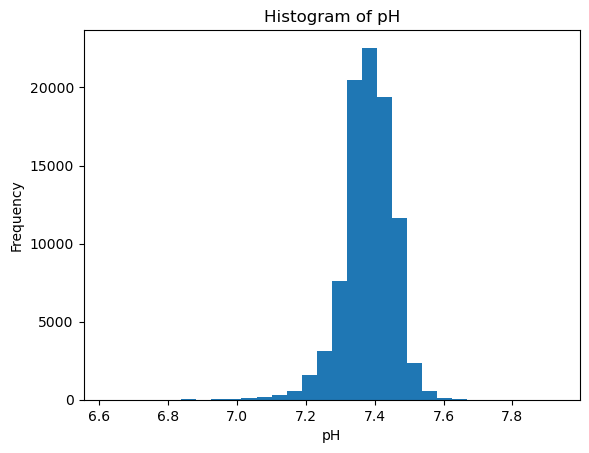

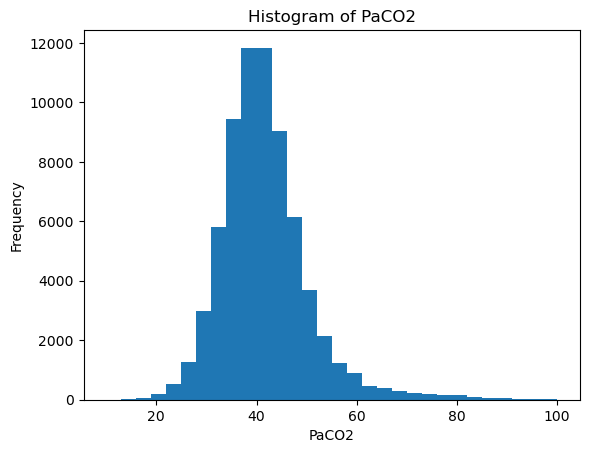

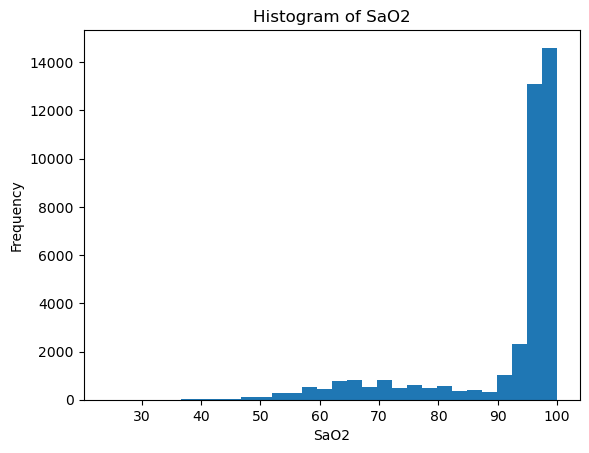

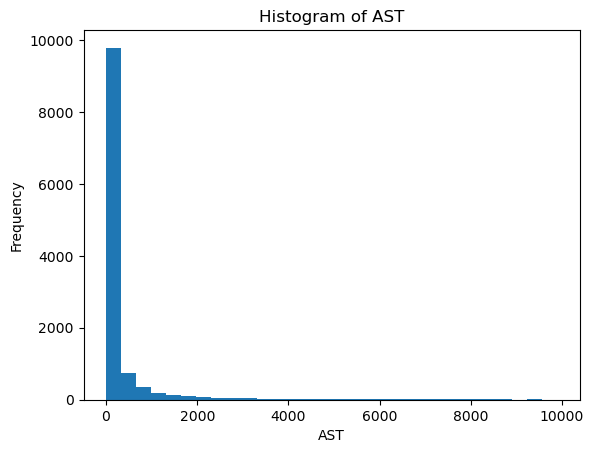

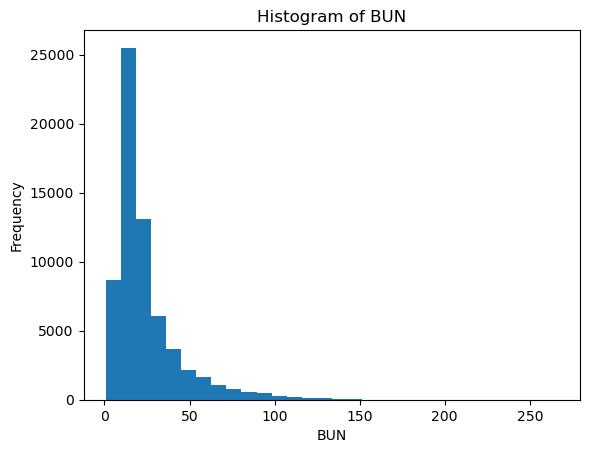

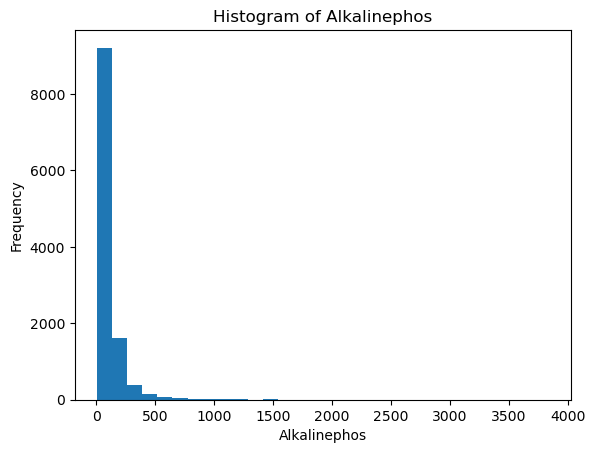

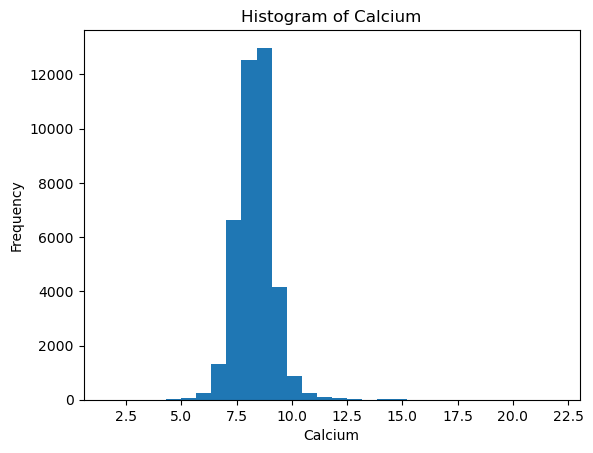

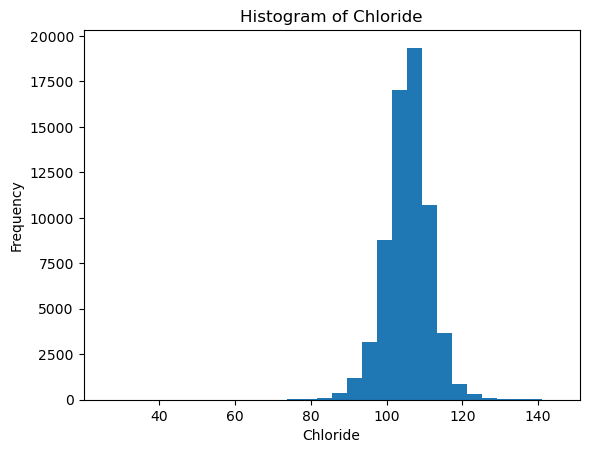

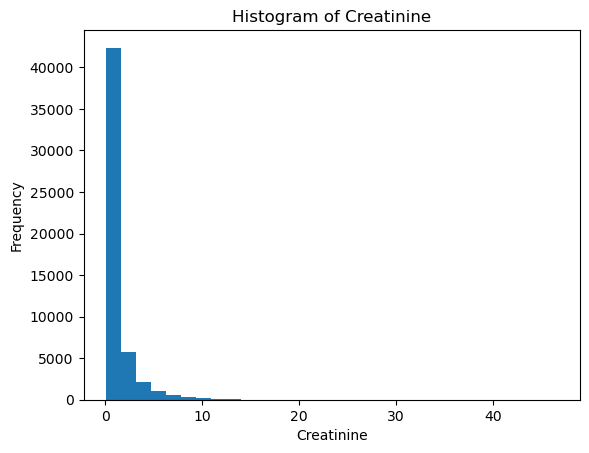

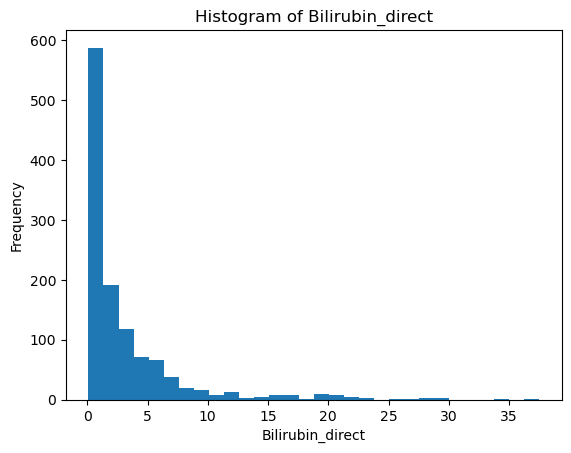

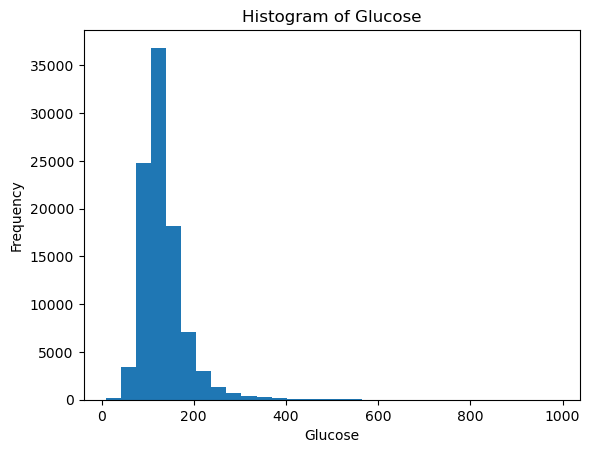

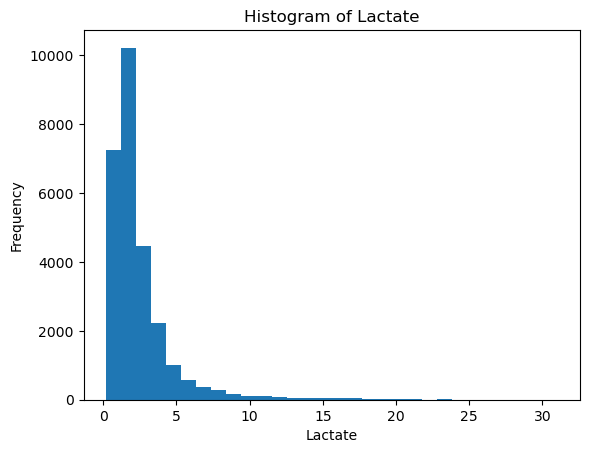

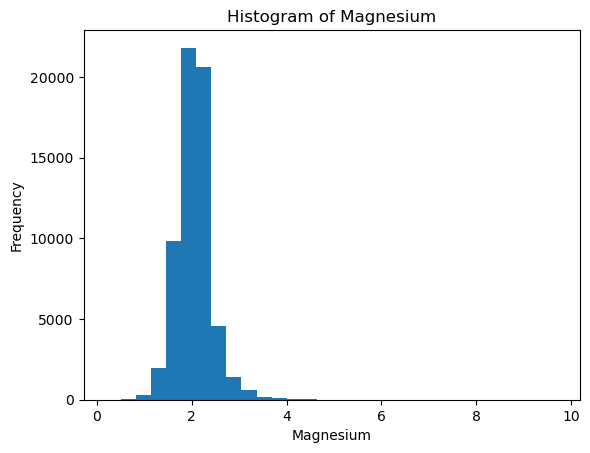

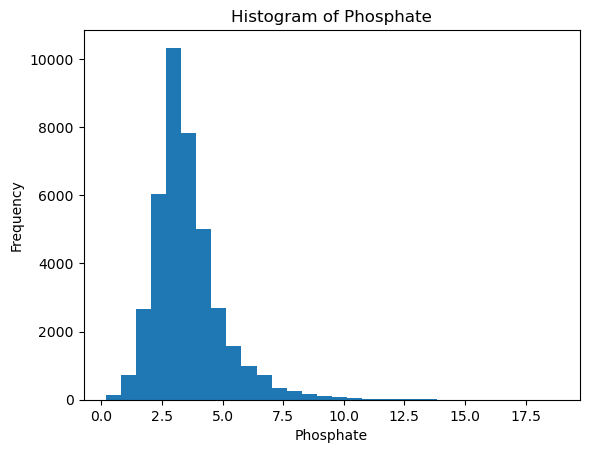

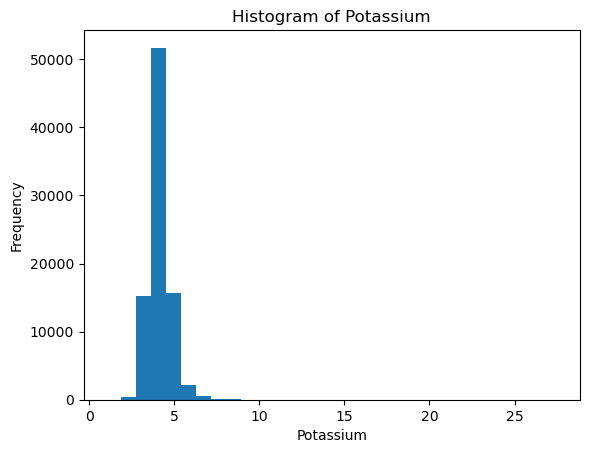

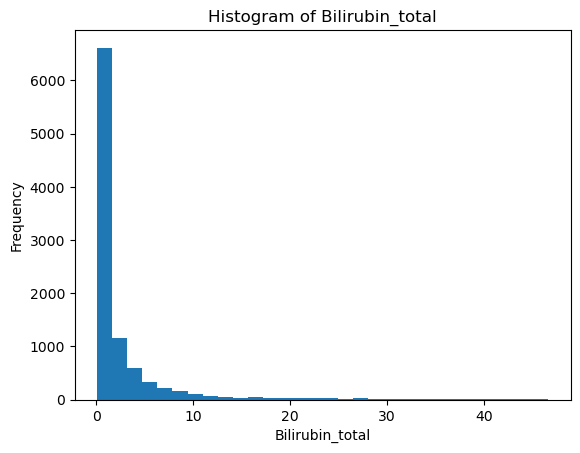

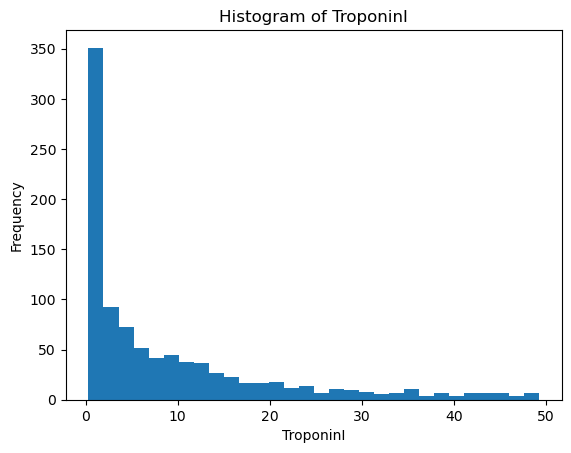

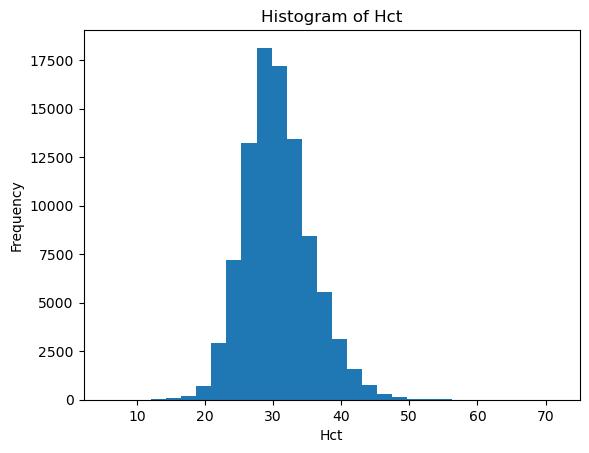

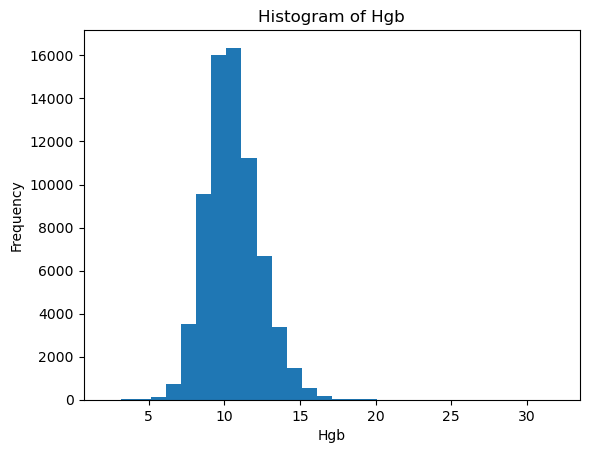

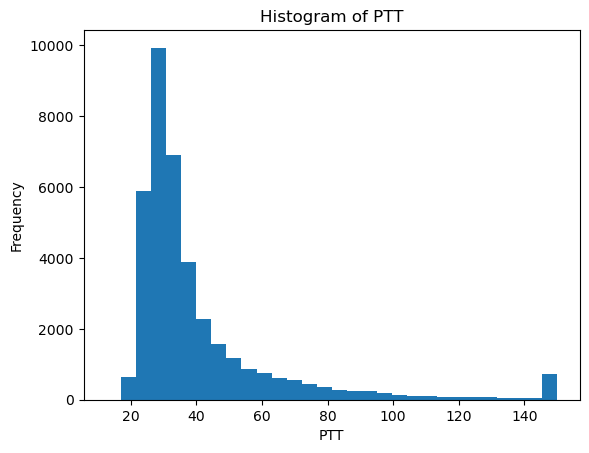

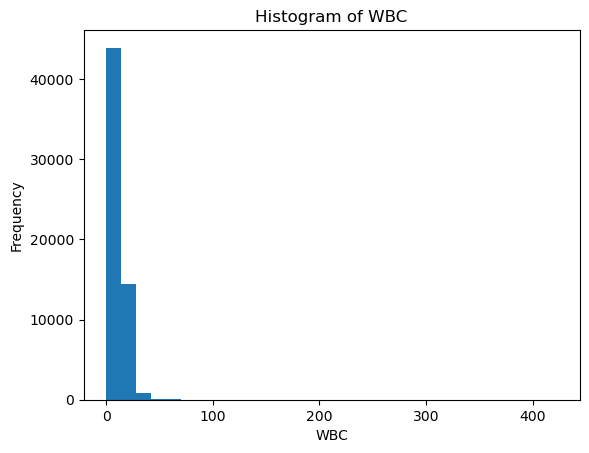

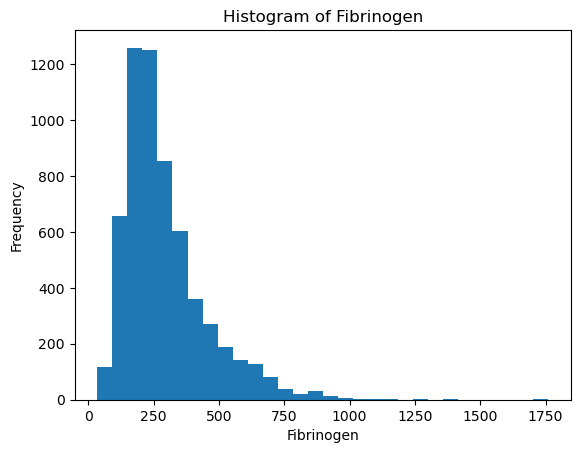

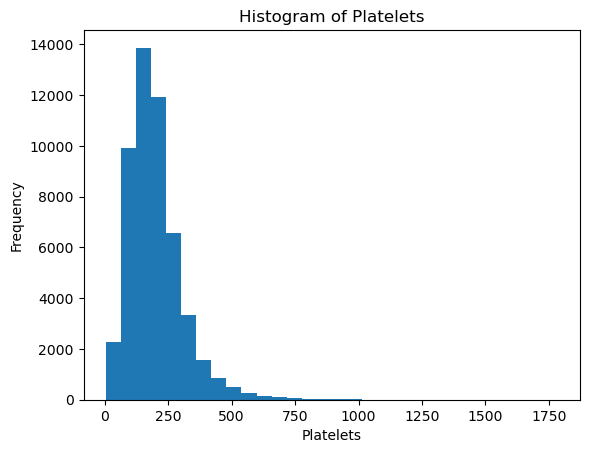

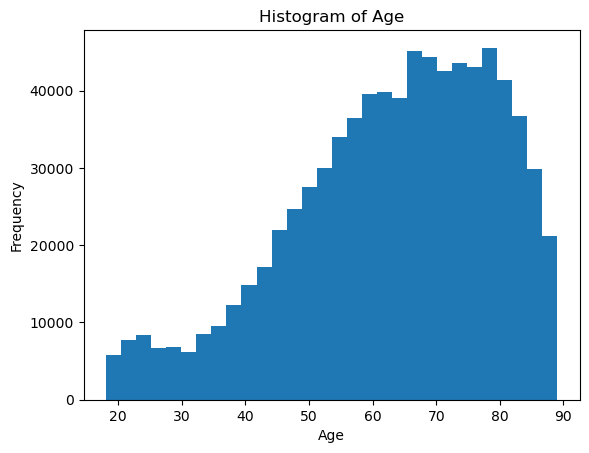

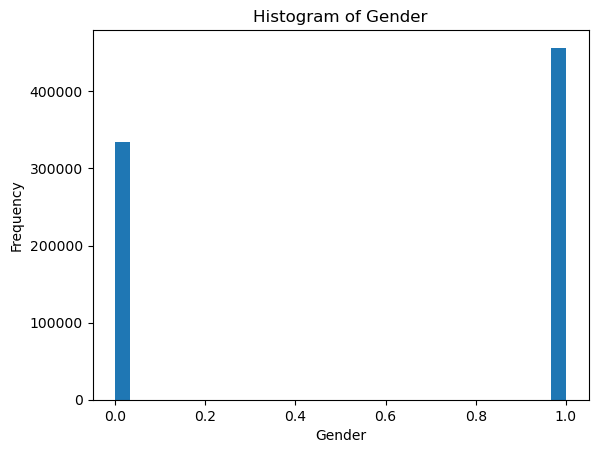

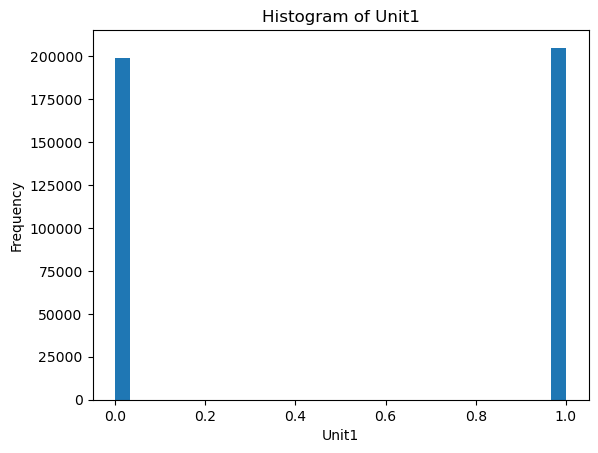

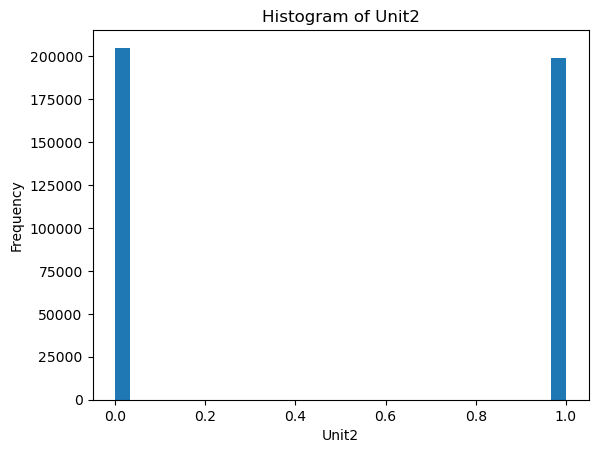

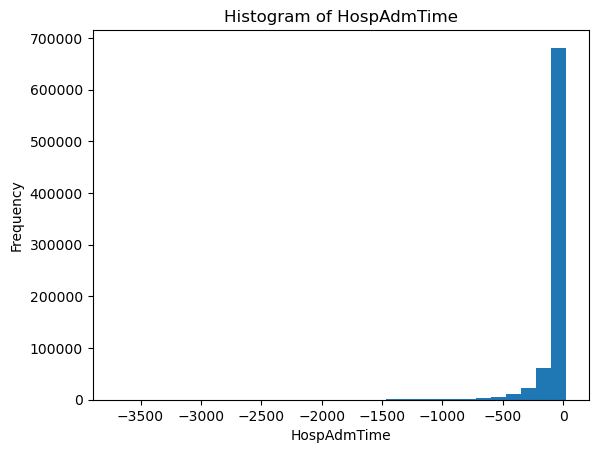

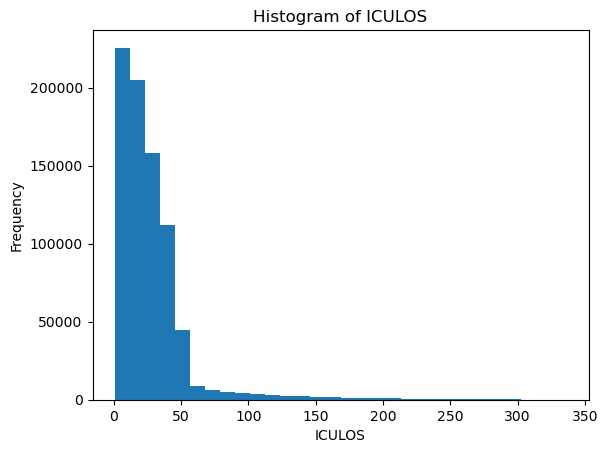

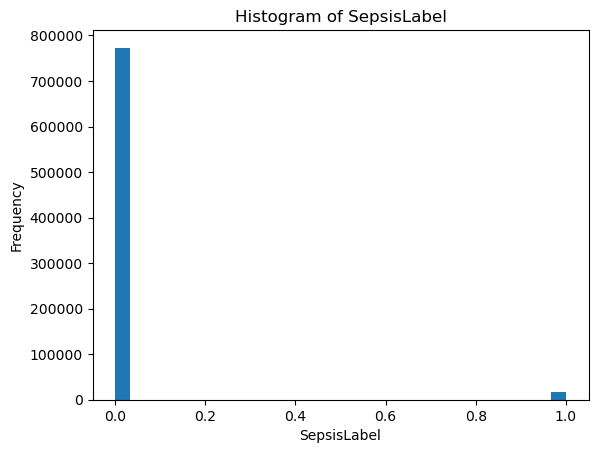

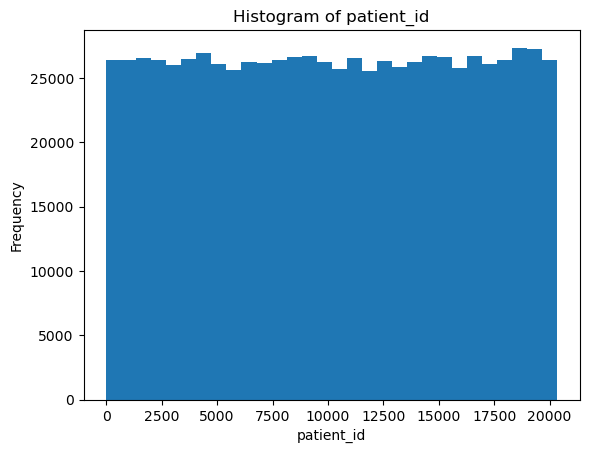

In [19]:
# Plot all num columns distribution
for column in full_df.columns:
    # Generate histogram for the current column
    plt.figure()  # Create a new figure for each column
    full_df[column].plot(kind='hist', bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()  # Display the histogram

## Initial Interpolation

In [20]:
# interpolate full df with different boundaries (1, 3, 5 missing values)
interpolation_limits = [1, 3, 5]

full_df_interpolated = [full_df.interpolate(limit=lim) for lim in interpolation_limits]

In [21]:
# interpolate full df with different boundaries (1, 3, 5 missing values)
#interpolation_limits = [1, 3, 5]

#full_df_interpolated = [pd.concat([d.interpolate(limit=lim) for d in full_df_from_disk]) for lim in interpolation_limits]

In [22]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

We see that the columns `Age, ICULOS, HospAdmTime, Gender` and `SepsisLabel` are thankfully complete. No need to interpolate those, dropping those for further analysis. `EtCO2` is dropped as it is missing data entirely.

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

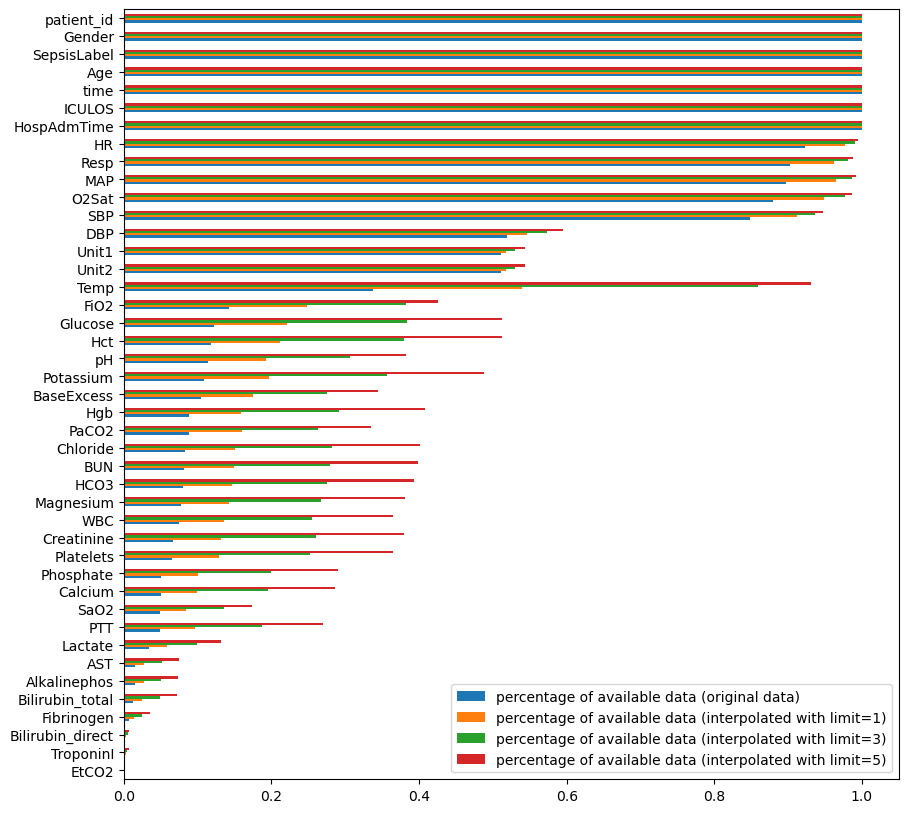

In [23]:
# recalculate with the smaller data frame.
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

fig, ax = plt.subplots()

value_availability_interpolated = [
    d.count().sort_values()/full_df.shape[0] for d in full_df_interpolated
]

res = pd.concat([value_availability, *value_availability_interpolated],axis=1)

res.plot.barh(figsize=(10,10), ax=ax)
ax.legend(["percentage of available data (original data)",
           *[f"percentage of available data (interpolated with limit={lim})" for lim in interpolation_limits]])

From the graph above, we conclude that interpolating with a gap of 3 has a noticeable impact while interpolation with a gap of 5 yields diminishing returns. To minimize skew, we choose a maximum gap of 3 for further processing.

## Analyse Feature Contribution

Now, we want to analyse which features are the most important sepsis predictors.

In [24]:
# As explained above, we choose a gap of 3
ref_df =full_df_interpolated[1].copy()
ref_df_cpy = ref_df.copy()
display(ref_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,0
1,1,97.0,95.0,NaN,98.0,75.330,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,0
2,2,89.0,99.0,NaN,122.0,86.000,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,0
3,3,90.0,95.0,NaN,122.0,88.665,NaN,30.0,NaN,24.000000,NaN,NaN,7.360000,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,0
4,4,103.0,88.5,NaN,122.0,91.330,NaN,24.5,NaN,23.857143,NaN,0.28,7.365714,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,28,88.0,98.0,38.5675,135.0,81.000,64.0,16.0,NaN,NaN,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,31,1,20335
790211,29,96.0,98.0,38.7200,174.0,97.000,72.0,16.0,NaN,2.000000,NaN,0.50,7.480000,34.0,97.000000,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,32,1,20335
790212,30,140.0,97.0,38.7200,133.0,81.500,62.5,16.0,NaN,2.000000,NaN,0.50,7.480000,34.0,97.333333,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,33,1,20335
790213,31,120.0,96.0,38.7200,154.0,118.000,105.0,16.0,NaN,2.000000,NaN,0.50,7.480000,34.0,97.666667,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,34,1,20335


### Using KNNs

In [25]:
print("std dev:")
#display(ref_df.std().sort_values(ascending=False))

ref_availability = ref_df.count().sort_values(ascending=False)/ref_df.shape[0]

print("availability")
display(ref_availability)

std dev:
availability


time                1.000000
Age                 1.000000
SepsisLabel         1.000000
ICULOS              1.000000
Gender              1.000000
patient_id          1.000000
HospAdmTime         0.999994
HR                  0.990349
MAP                 0.986039
Resp                0.981125
O2Sat               0.977073
SBP                 0.936517
Temp                0.859199
DBP                 0.572947
Unit2               0.530462
Unit1               0.530462
Glucose             0.383635
FiO2                0.382857
Hct                 0.379570
Potassium           0.356451
pH                  0.305928
Hgb                 0.290839
Chloride            0.281659
BUN                 0.278744
HCO3                0.274737
BaseExcess          0.274619
Magnesium           0.266598
PaCO2               0.263378
Creatinine          0.260700
WBC                 0.255000
Platelets           0.252148
Phosphate           0.198807
Calcium             0.195952
PTT                 0.186897
SaO2          

In [26]:
import math
def classify_pairs(df):
  """Take pairs of time series values and assign a sepsis_class as follows:
  00: A
  01: B
  10: C
  11: D

  Ensures that no comparisons are done between patients.
  """
  sepsis_label_df = df.diff()["SepsisLabel"].replace({1: "B", -1: "C"})
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 0)["SepsisLabel"])] = "A"
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 1)["SepsisLabel"])] = "D"
  sepsis_label_df[df.diff()["patient_id"] != 0] = math.nan

  _df = df.copy()
  _df["SepsisClass"] = sepsis_label_df
  return _df

As an aside: in this data set, patients do not leave the state of a septic patient.

In [27]:
print("distribution of transitions: A remains non-septic, B becomes septic, D remains septic")
sepsis_class_df = classify_pairs(ref_df)
display(sepsis_class_df["SepsisClass"].value_counts())
print("sanity check: overall (non-)septic timestamps")
display(ref_df["SepsisLabel"].value_counts())

distribution of transitions: A remains non-septic, B becomes septic, D remains septic


A    752946
D     15346
B      1587
Name: SepsisClass, dtype: int64

sanity check: overall (non-)septic timestamps


0    773079
1     17136
Name: SepsisLabel, dtype: int64

In the following cell, normalization can be activated.

Normalization is generally considered to be best practise.
During testing however, we found out that normalization of the most important and the most readily available variables did not result in an improved model (w.r.t. the metrics in the classification report), independent from the method used (standard/min-max). Often, fitting was considerably (\~25%) faster. Due to low fitting time overall (\~3 min), this advantage is neglibile. 
Normalization of all model variables even decreased model performance significantly. Standard scaling was found to have a larger impact than min-max scaling. Linearlizing the pH had a negative effect on model performance.

Those results are quite surprising and warrant further research.

Also, in the next cell, columns can be dropped from the data. From the most important variables (the calculation will follow in a few cells), `time`, `ICULOS` are strange candidates in the sense that they represent time but not state. The onset of sepsis does require a certain development which generates dependencies on immune system damage, inflammation state, ..., but there is no dependency on time itself. That makes those reasonable candidates for dropping. Doing so does decrease recall from 0.44 to 0.16 for the sklearn model and from 0.58 to 0.24 for the xgboost model however. Such strong dependence on time might be questionable in the final model.

Additionally, there is a variable `HospAdmTime` (the time between hospital and ICU admit) which is a measure for perceived urgency. The variable strongly influences both models, to the point where omission leads to recall dropping to 0.22 for sklearn and 0.32 for the xgboost model. This parameter does not consider physiological conditions but rather human experience and judgement. Heavy dependence on such variables is not desired.

In [28]:
import xgboost as xgb

# try random forest as outlined here: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# one hot encoding is skipped (we only have binary or continous data, nothing categorical)
# we also don't have temporal variables

# we can try the following data sets:
# original data (classified as sepsis/non-sepsis)
# original data (classified as transitions)
# pairs of data (classified as transitions)
normalization = False

if normalization:
    # linearize all scales in the reference data.
    ref_df["pH"]=10**(-ref_df["pH"])

    # min-max scaling or stanard scaling
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    # available columns with numerical values are:
    cols_to_norm = ['HR', 'O2Sat', 'Temp', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
                    'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
                    'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen',
                    'Platelets', 'Age', 'ICULOS']
    
    
    ref_df[cols_to_norm] = MinMaxScaler().fit_transform(ref_df[cols_to_norm])

labels = np.array(ref_df['SepsisLabel'])
# XGBoost learns heavily on patient_id which is not desired.
# Also, further columns to drop can be specified here. See the comment above
ref_df_nosepsis = ref_df.drop(['SepsisLabel', 'patient_id'], axis = 1)
ref_df_names = list(ref_df_nosepsis.columns)
ref_df_as_array = np.array(ref_df_nosepsis)

display(ref_df_nosepsis)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(ref_df_as_array, labels, test_size = 0.25, random_state = 42)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1
1,1,97.0,95.0,NaN,98.0,75.330,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2
2,2,89.0,99.0,NaN,122.0,86.000,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3
3,3,90.0,95.0,NaN,122.0,88.665,NaN,30.0,NaN,24.000000,NaN,NaN,7.360000,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4
4,4,103.0,88.5,NaN,122.0,91.330,NaN,24.5,NaN,23.857143,NaN,0.28,7.365714,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,28,88.0,98.0,38.5675,135.0,81.000,64.0,16.0,NaN,NaN,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,31
790211,29,96.0,98.0,38.7200,174.0,97.000,72.0,16.0,NaN,2.000000,NaN,0.50,7.480000,34.0,97.000000,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,32
790212,30,140.0,97.0,38.7200,133.0,81.500,62.5,16.0,NaN,2.000000,NaN,0.50,7.480000,34.0,97.333333,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,33
790213,31,120.0,96.0,38.7200,154.0,118.000,105.0,16.0,NaN,2.000000,NaN,0.50,7.480000,34.0,97.666667,90.0,26.0,107.0,NaN,NaN,2.5,NaN,NaN,NaN,2.2,3.5,3.9,0.9,NaN,27.8,NaN,NaN,NaN,NaN,NaN,62.29,1,NaN,NaN,-0.03,34


### sklearn trees (hist gradient boosting)

We will try two approaches to build random forests.

The first one will feature the HistGradientBoostingClassifier from sklearn.
Sklearn also features a RandomForestClassifier but that one cannot work with NaN values. That is quite unfortunate as the
RandomForestClassifier would give importances directly, which we have to compute quite costly now.

In [29]:
# Import the model we are using
from sklearn.ensemble import HistGradientBoostingClassifier # Instantiate model with 1000 decision trees
## PREPARE ##
rf = HistGradientBoostingClassifier(verbose=1, max_depth=10, max_iter=2500, random_state = 43)
## TRAIN ##
est = rf.fit(train_features, train_labels);

Binning 0.175 GB of training data: 0.819 s
Binning 0.019 GB of validation data: 0.043 s
Fitting gradient boosted rounds:
[1/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.09869, val loss: 0.09893, in 0.115s
[2/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.09608, val loss: 0.09658, in 0.129s
[3/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.09418, val loss: 0.09501, in 0.135s
[4/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.09275, val loss: 0.09371, in 0.141s
[5/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.09162, val loss: 0.09265, in 0.147s
[6/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.09057, val loss: 0.09183, in 0.163s
[7/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.08975, val loss: 0.09115, in 0.152s
[8/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.08896, val loss: 0.09047, in 0.119s
[9/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.08826, val loss: 0.08992, in 0.122s
[10/2500] 1 tree, 31 leaves, max depth 

[87/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07244, val loss: 0.07949, in 0.063s
[88/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07235, val loss: 0.07940, in 0.063s
[89/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07225, val loss: 0.07936, in 0.081s
[90/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07213, val loss: 0.07931, in 0.068s
[91/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07205, val loss: 0.07928, in 0.068s
[92/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07192, val loss: 0.07922, in 0.080s
[93/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07185, val loss: 0.07922, in 0.063s
[94/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07177, val loss: 0.07914, in 0.066s
[95/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07171, val loss: 0.07909, in 0.070s
[96/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.07162, val loss: 0.07904, in 0.077s
[97/2500] 1 tree, 31 leaves, max depth = 10, train

[173/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06534, val loss: 0.07542, in 0.087s
[174/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06526, val loss: 0.07539, in 0.082s
[175/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.06522, val loss: 0.07534, in 0.092s
[176/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06503, val loss: 0.07511, in 0.103s
[177/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.06492, val loss: 0.07505, in 0.113s
[178/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06475, val loss: 0.07497, in 0.111s
[179/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06469, val loss: 0.07494, in 0.088s
[180/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06456, val loss: 0.07489, in 0.106s
[181/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06450, val loss: 0.07486, in 0.100s
[182/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.06436, val loss: 0.07482, in 0.116s
[183/2500] 1 tree, 31 leaves, max depth = 

[259/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05927, val loss: 0.07176, in 0.095s
[260/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05917, val loss: 0.07170, in 0.084s
[261/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05914, val loss: 0.07168, in 0.068s
[262/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05909, val loss: 0.07167, in 0.075s
[263/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05906, val loss: 0.07166, in 0.069s
[264/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05901, val loss: 0.07163, in 0.082s
[265/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05897, val loss: 0.07162, in 0.066s
[266/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05890, val loss: 0.07159, in 0.096s
[267/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05884, val loss: 0.07157, in 0.062s
[268/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05875, val loss: 0.07150, in 0.076s
[269/2500] 1 tree, 31 leaves, max depth 

[345/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05475, val loss: 0.06940, in 0.082s
[346/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05467, val loss: 0.06937, in 0.060s
[347/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.05464, val loss: 0.06934, in 0.058s
[348/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05461, val loss: 0.06933, in 0.082s
[349/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05456, val loss: 0.06930, in 0.075s
[350/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05452, val loss: 0.06929, in 0.061s
[351/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05445, val loss: 0.06928, in 0.071s
[352/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05439, val loss: 0.06923, in 0.080s
[353/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05436, val loss: 0.06923, in 0.060s
[354/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05432, val loss: 0.06923, in 0.075s
[355/2500] 1 tree, 31 leaves, max depth =

[431/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05066, val loss: 0.06718, in 0.093s
[432/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05063, val loss: 0.06719, in 0.062s
[433/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05056, val loss: 0.06713, in 0.068s
[434/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05054, val loss: 0.06713, in 0.060s
[435/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05051, val loss: 0.06712, in 0.060s
[436/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05049, val loss: 0.06711, in 0.068s
[437/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05047, val loss: 0.06710, in 0.067s
[438/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.05045, val loss: 0.06709, in 0.096s
[439/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05039, val loss: 0.06705, in 0.076s
[440/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.05034, val loss: 0.06702, in 0.069s
[441/2500] 1 tree, 31 leaves, max depth =

[517/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04697, val loss: 0.06518, in 0.059s
[518/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04693, val loss: 0.06517, in 0.079s
[519/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04684, val loss: 0.06515, in 0.072s
[520/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04675, val loss: 0.06508, in 0.076s
[521/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04672, val loss: 0.06507, in 0.084s
[522/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04670, val loss: 0.06506, in 0.062s
[523/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.04668, val loss: 0.06505, in 0.064s
[524/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04664, val loss: 0.06504, in 0.076s
[525/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04662, val loss: 0.06503, in 0.061s
[526/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.04660, val loss: 0.06503, in 0.101s
[527/2500] 1 tree, 31 leaves, max depth = 

[603/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04378, val loss: 0.06303, in 0.083s
[604/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04376, val loss: 0.06302, in 0.080s
[605/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04374, val loss: 0.06300, in 0.088s
[606/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04372, val loss: 0.06299, in 0.080s
[607/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04370, val loss: 0.06296, in 0.089s
[608/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04365, val loss: 0.06293, in 0.102s
[609/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04360, val loss: 0.06290, in 0.107s
[610/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04357, val loss: 0.06288, in 0.095s
[611/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04354, val loss: 0.06286, in 0.088s
[612/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04352, val loss: 0.06285, in 0.103s
[613/2500] 1 tree, 31 leaves, max depth 

[689/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04044, val loss: 0.06082, in 0.062s
[690/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04043, val loss: 0.06081, in 0.060s
[691/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04041, val loss: 0.06079, in 0.070s
[692/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04040, val loss: 0.06078, in 0.064s
[693/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04034, val loss: 0.06076, in 0.070s
[694/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04030, val loss: 0.06073, in 0.084s
[695/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.04028, val loss: 0.06073, in 0.066s
[696/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04025, val loss: 0.06071, in 0.062s
[697/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04020, val loss: 0.06066, in 0.084s
[698/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.04017, val loss: 0.06067, in 0.073s
[699/2500] 1 tree, 31 leaves, max depth =

[775/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03787, val loss: 0.05928, in 0.123s
[776/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03786, val loss: 0.05927, in 0.092s
[777/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03782, val loss: 0.05925, in 0.106s
[778/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03781, val loss: 0.05926, in 0.088s
[779/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03778, val loss: 0.05924, in 0.095s
[780/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.03777, val loss: 0.05923, in 0.088s
[781/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03773, val loss: 0.05921, in 0.115s
[782/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03769, val loss: 0.05918, in 0.102s
[783/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03767, val loss: 0.05916, in 0.080s
[784/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03764, val loss: 0.05915, in 0.114s
[785/2500] 1 tree, 31 leaves, max depth =

[861/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03568, val loss: 0.05813, in 0.088s
[862/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03563, val loss: 0.05808, in 0.080s
[863/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.03557, val loss: 0.05801, in 0.066s
[864/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03552, val loss: 0.05798, in 0.082s
[865/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03551, val loss: 0.05796, in 0.058s
[866/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.03550, val loss: 0.05795, in 0.066s
[867/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03549, val loss: 0.05794, in 0.073s
[868/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03547, val loss: 0.05793, in 0.069s
[869/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03546, val loss: 0.05794, in 0.059s
[870/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03543, val loss: 0.05790, in 0.067s
[871/2500] 1 tree, 31 leaves, max depth = 

[947/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03330, val loss: 0.05655, in 0.076s
[948/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03328, val loss: 0.05654, in 0.084s
[949/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.03327, val loss: 0.05653, in 0.066s
[950/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03325, val loss: 0.05653, in 0.064s
[951/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03324, val loss: 0.05653, in 0.061s
[952/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03322, val loss: 0.05652, in 0.090s
[953/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03320, val loss: 0.05650, in 0.068s
[954/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03317, val loss: 0.05649, in 0.068s
[955/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03316, val loss: 0.05649, in 0.068s
[956/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03315, val loss: 0.05648, in 0.078s
[957/2500] 1 tree, 31 leaves, max depth =

[1032/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03131, val loss: 0.05547, in 0.065s
[1033/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03129, val loss: 0.05546, in 0.101s
[1034/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03127, val loss: 0.05545, in 0.062s
[1035/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03120, val loss: 0.05543, in 0.084s
[1036/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03118, val loss: 0.05544, in 0.058s
[1037/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03116, val loss: 0.05543, in 0.079s
[1038/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03111, val loss: 0.05539, in 0.086s
[1039/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03110, val loss: 0.05539, in 0.065s
[1040/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03109, val loss: 0.05538, in 0.067s
[1041/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.03107, val loss: 0.05537, in 0.070s
[1042/2500] 1 tree, 31 leaves,

[1117/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02949, val loss: 0.05457, in 0.088s
[1118/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02948, val loss: 0.05456, in 0.068s
[1119/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02946, val loss: 0.05454, in 0.083s
[1120/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02943, val loss: 0.05453, in 0.072s
[1121/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02940, val loss: 0.05452, in 0.095s
[1122/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02936, val loss: 0.05447, in 0.088s
[1123/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02935, val loss: 0.05447, in 0.066s
[1124/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02931, val loss: 0.05445, in 0.091s
[1125/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02931, val loss: 0.05445, in 0.073s
[1126/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02929, val loss: 0.05445, in 0.074s
[1127/2500] 1 tree, 31 leaves,

[1202/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02761, val loss: 0.05350, in 0.094s
[1203/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02757, val loss: 0.05350, in 0.131s
[1204/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02755, val loss: 0.05348, in 0.109s
[1205/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02754, val loss: 0.05345, in 0.086s
[1206/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02753, val loss: 0.05344, in 0.088s
[1207/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02749, val loss: 0.05340, in 0.121s
[1208/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02744, val loss: 0.05336, in 0.133s
[1209/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02742, val loss: 0.05335, in 0.093s
[1210/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02739, val loss: 0.05334, in 0.120s
[1211/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02738, val loss: 0.05335, in 0.083s
[1212/2500] 1 tree, 31 leaves, ma

[1287/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02590, val loss: 0.05233, in 0.080s
[1288/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02588, val loss: 0.05234, in 0.080s
[1289/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02586, val loss: 0.05234, in 0.068s
[1290/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02584, val loss: 0.05232, in 0.076s
[1291/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02580, val loss: 0.05229, in 0.084s
[1292/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02578, val loss: 0.05228, in 0.085s
[1293/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02576, val loss: 0.05227, in 0.073s
[1294/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02573, val loss: 0.05225, in 0.092s
[1295/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02572, val loss: 0.05224, in 0.065s
[1296/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02570, val loss: 0.05224, in 0.071s
[1297/2500] 1 tree, 31 leaves,

[1372/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02461, val loss: 0.05169, in 0.092s
[1373/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02459, val loss: 0.05168, in 0.109s
[1374/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02457, val loss: 0.05167, in 0.090s
[1375/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02456, val loss: 0.05166, in 0.107s
[1376/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02453, val loss: 0.05165, in 0.139s
[1377/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02452, val loss: 0.05165, in 0.125s
[1378/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02449, val loss: 0.05162, in 0.150s
[1379/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02446, val loss: 0.05161, in 0.143s
[1380/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02445, val loss: 0.05161, in 0.104s
[1381/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02444, val loss: 0.05160, in 0.109s
[1382/2500] 1 tree, 31 leaves,

[1457/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.02342, val loss: 0.05095, in 0.081s
[1458/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02341, val loss: 0.05093, in 0.081s
[1459/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02340, val loss: 0.05094, in 0.140s
[1460/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02338, val loss: 0.05094, in 0.089s
[1461/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02337, val loss: 0.05094, in 0.073s
[1462/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02333, val loss: 0.05090, in 0.078s
[1463/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02332, val loss: 0.05090, in 0.066s
[1464/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02332, val loss: 0.05090, in 0.068s
[1465/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02331, val loss: 0.05089, in 0.070s
[1466/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02330, val loss: 0.05088, in 0.071s
[1467/2500] 1 tree, 31 leaves, m

[1542/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.02220, val loss: 0.05033, in 0.105s
[1543/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02219, val loss: 0.05032, in 0.090s
[1544/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02217, val loss: 0.05031, in 0.103s
[1545/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02217, val loss: 0.05031, in 0.102s
[1546/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02215, val loss: 0.05030, in 0.093s
[1547/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02215, val loss: 0.05029, in 0.106s
[1548/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02214, val loss: 0.05028, in 0.100s
[1549/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02213, val loss: 0.05027, in 0.095s
[1550/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02211, val loss: 0.05027, in 0.127s
[1551/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02210, val loss: 0.05026, in 0.120s
[1552/2500] 1 tree, 31 leaves, m

[1627/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02092, val loss: 0.04965, in 0.096s
[1628/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02090, val loss: 0.04965, in 0.076s
[1629/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02089, val loss: 0.04965, in 0.081s
[1630/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02088, val loss: 0.04964, in 0.072s
[1631/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02086, val loss: 0.04964, in 0.066s
[1632/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02086, val loss: 0.04963, in 0.067s
[1633/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02084, val loss: 0.04962, in 0.098s
[1634/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02083, val loss: 0.04963, in 0.082s
[1635/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.02083, val loss: 0.04963, in 0.072s
[1636/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.02082, val loss: 0.04963, in 0.080s
[1637/2500] 1 tree, 31 leaves, m

[1711/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01978, val loss: 0.04904, in 0.086s
[1712/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01977, val loss: 0.04905, in 0.082s
[1713/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01976, val loss: 0.04903, in 0.108s
[1714/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01975, val loss: 0.04904, in 0.093s
[1715/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01974, val loss: 0.04902, in 0.131s
[1716/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01973, val loss: 0.04902, in 0.092s
[1717/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01971, val loss: 0.04900, in 0.108s
[1718/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01969, val loss: 0.04900, in 0.084s
[1719/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01968, val loss: 0.04898, in 0.090s
[1720/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01967, val loss: 0.04898, in 0.070s
[1721/2500] 1 tree, 31 leaves, 

[1796/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01888, val loss: 0.04865, in 0.066s
[1797/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01888, val loss: 0.04865, in 0.066s
[1798/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01888, val loss: 0.04864, in 0.062s
[1799/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01887, val loss: 0.04864, in 0.070s
[1800/2500] 1 tree, 31 leaves, max depth = 7, train loss: 0.01886, val loss: 0.04864, in 0.068s
[1801/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01885, val loss: 0.04862, in 0.072s
[1802/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01885, val loss: 0.04862, in 0.071s
[1803/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01884, val loss: 0.04860, in 0.086s
[1804/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01883, val loss: 0.04860, in 0.064s
[1805/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01883, val loss: 0.04859, in 0.061s
[1806/2500] 1 tree, 31 leaves, max

[1881/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01799, val loss: 0.04819, in 0.083s
[1882/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01798, val loss: 0.04819, in 0.063s
[1883/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01797, val loss: 0.04819, in 0.062s
[1884/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01795, val loss: 0.04818, in 0.065s
[1885/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01793, val loss: 0.04818, in 0.079s
[1886/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01793, val loss: 0.04817, in 0.072s
[1887/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01793, val loss: 0.04817, in 0.067s
[1888/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01792, val loss: 0.04817, in 0.059s
[1889/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01791, val loss: 0.04817, in 0.066s
[1890/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01791, val loss: 0.04816, in 0.079s
[1891/2500] 1 tree, 31 leaves,

[1966/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01706, val loss: 0.04769, in 0.064s
[1967/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01706, val loss: 0.04769, in 0.063s
[1968/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01705, val loss: 0.04769, in 0.069s
[1969/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01704, val loss: 0.04768, in 0.065s
[1970/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.01704, val loss: 0.04767, in 0.074s
[1971/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01703, val loss: 0.04767, in 0.071s
[1972/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01700, val loss: 0.04764, in 0.073s
[1973/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01700, val loss: 0.04764, in 0.073s
[1974/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01698, val loss: 0.04762, in 0.089s
[1975/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01697, val loss: 0.04761, in 0.071s
[1976/2500] 1 tree, 31 leaves, ma

[2051/2500] 1 tree, 31 leaves, max depth = 9, train loss: 0.01619, val loss: 0.04729, in 0.065s
[2052/2500] 1 tree, 31 leaves, max depth = 8, train loss: 0.01619, val loss: 0.04729, in 0.071s
[2053/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01618, val loss: 0.04729, in 0.065s
[2054/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01617, val loss: 0.04728, in 0.063s
[2055/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01616, val loss: 0.04730, in 0.072s
[2056/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01614, val loss: 0.04729, in 0.082s
[2057/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01612, val loss: 0.04728, in 0.080s
[2058/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01611, val loss: 0.04728, in 0.080s
[2059/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01608, val loss: 0.04725, in 0.085s
[2060/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01608, val loss: 0.04725, in 0.084s
[2061/2500] 1 tree, 31 leaves, m

[2135/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01539, val loss: 0.04686, in 0.102s
[2136/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01538, val loss: 0.04686, in 0.083s
[2137/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01536, val loss: 0.04686, in 0.088s
[2138/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01534, val loss: 0.04685, in 0.107s
[2139/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01534, val loss: 0.04686, in 0.081s
[2140/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01534, val loss: 0.04685, in 0.117s
[2141/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01533, val loss: 0.04685, in 0.122s
[2142/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01532, val loss: 0.04685, in 0.072s
[2143/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01531, val loss: 0.04685, in 0.098s
[2144/2500] 1 tree, 31 leaves, max depth = 10, train loss: 0.01531, val loss: 0.04685, in 0.069s
[2145/2500] 1 tree, 31 leaves,

We see good convergence and early stopping (well before the maximum 2500 steps).

array([0.10423588, 0.09868886, 0.09607787, 0.09418175, 0.09275317,
       0.09162169, 0.09056582, 0.08975009, 0.08896211, 0.08826135])

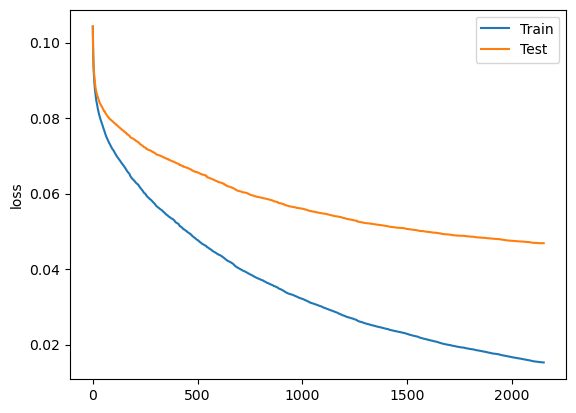

In [30]:
display(-1*est.train_score_[0:10])
x_axis = range(0, len(est.train_score_))
fig, ax = plt.subplots()
ax.plot(x_axis, -1*est.train_score_, label='Train')
ax.plot(x_axis, -1*est.validation_score_, label='Test')
ax.legend()
plt.ylabel('loss')
plt.show()

In [31]:
## EVALUATE ##
# Confusion matrices give a better idea of how good we are:
# https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

print(f"test data accuracy: {est.score(train_features, train_labels)}")
print(f"validation data accuracy: {est.score(test_features, test_labels)}")

test data accuracy: 0.994742356929172
validation data accuracy: 0.983913259159521


We can also calculate some other metrices. Most importantly, in the classification report, the model behaves well except for sepsis recall (recognizing actual sepsis/sensitivity). We want to improve this metric in particular. Consequently, the resulting F1 score is mediocre.

In [32]:
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
np.set_printoptions(suppress=True)

preds = est.predict(test_features)


# pos_label=1 (the default) is correct for us.
print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(f"recall: {recall_score(test_labels, preds)}")
print(f"balanced accuracy: {balanced_accuracy_score(test_labels, preds)}")
print(f"f1 score: {f1_score(test_labels, preds)}")
print(f"confusion matrix (non-normalized):\n {confusion_matrix(test_labels, preds, normalize=None)}")
print(f"confusion matrix (normalized over true classes/rows):\n {confusion_matrix(test_labels, preds, normalize='true')}")

print(classification_report(test_labels, preds, target_names=["no sepsis", "sepsis"]))

accuracy: 0.983913259159521
recall: 0.2912912912912913
balanced accuracy: 0.6453610033892088
f1 score: 0.4424561403508772
confusion matrix (non-normalized):
 [[193115    110]
 [  3068   1261]]
confusion matrix (normalized over true classes/rows):
 [[0.99943072 0.00056928]
 [0.70870871 0.29129129]]
              precision    recall  f1-score   support

   no sepsis       0.98      1.00      0.99    193225
      sepsis       0.92      0.29      0.44      4329

    accuracy                           0.98    197554
   macro avg       0.95      0.65      0.72    197554
weighted avg       0.98      0.98      0.98    197554



We can also deduct the importances of model variables but be warned that the following cell will take a lot of time.

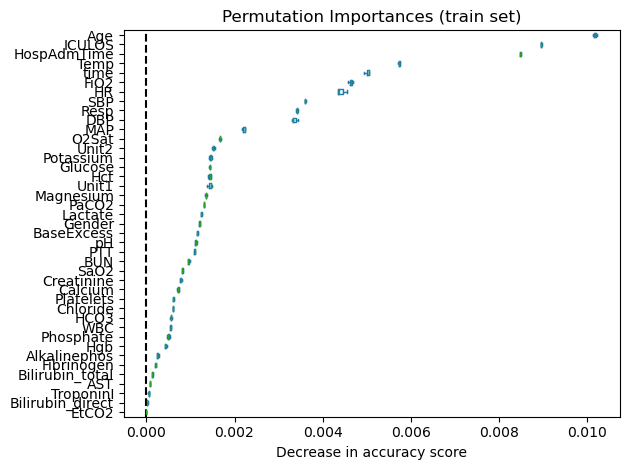

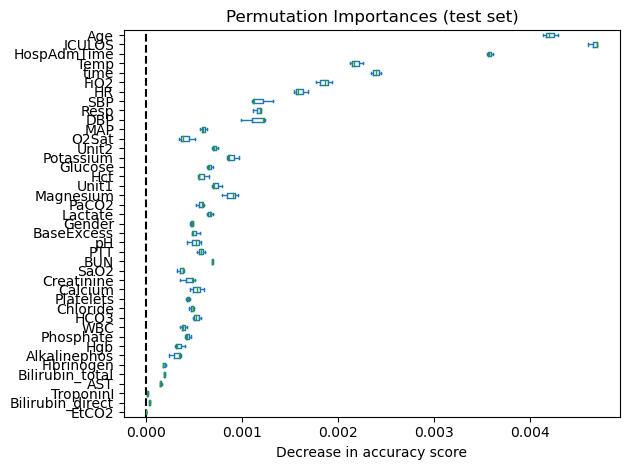

In [33]:
# runtime:
# model iterations | time
# 10               | 2:26
# 20               | 4:08
# 30               | 6 min (?)
# 40               | 7:54
# 100              | 17:19
# 700              | 1:51:34
# As this has complexity in O(n^2), where n is the number of model parameters
# (roughly 50 in our case), we expect this value to decrease a lot after parameter
# elimination

if True:

    # see here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
    from sklearn.inspection import permutation_importance


    train_result = permutation_importance(
        rf, train_features, train_labels, n_repeats=3, random_state=42, n_jobs=-1
    )
    test_results = permutation_importance(
        rf, test_features, test_labels, n_repeats=3, random_state=42, n_jobs=-1
    )
    sorted_importances_idx = train_result.importances_mean.argsort()

    train_importances = pd.DataFrame(
        train_result.importances[sorted_importances_idx].T,
        columns=ref_df.columns[sorted_importances_idx],
    )
    test_importances = pd.DataFrame(
        test_results.importances[sorted_importances_idx].T,
        columns=ref_df.columns[sorted_importances_idx],
    )

    for name, importances in zip(["train", "test"], [train_importances, test_importances]):
        ax = importances.plot.box(vert=False, whis=10)
        ax.set_title(f"Permutation Importances ({name} set)")
        ax.set_xlabel("Decrease in accuracy score")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.figure.tight_layout()

### XGBoost

The second approach is done using XGBoost, a specialized library for boosted random forests. The setup is a bit more involved but the results are very promising.

In [34]:
## PREPARE ##
from sklearn.utils.class_weight import compute_sample_weight

# prepare data for use with XGBoost.
# from https://www.datacamp.com/tutorial/xgboost-in-python
dtrain_clf = xgb.DMatrix(train_features, train_labels, feature_names=ref_df_names, enable_categorical=True)
dtest_clf = xgb.DMatrix(test_features, test_labels, feature_names=ref_df_names, enable_categorical=True)

evals_result = {}

## TRAIN ##
# to convert the SepsisClass (which is not used yet) you have to use a numerical
# representation, where the following snippet might come in handy:
# Encode y to numeric
# y_encoded = OrdinalEncoder().fit_transform(y)
# binary:logistic will give output _probabilites_
# binary:hinge gives *by far* worse results than multi:softmax (earlier stopping, worse recall). Very confusing!
params = {#"objective": "binary:hinge",
          "objective": "multi:softmax",
          "tree_method": "hist",
          "max_depth": 7,
          "num_class": 2
}

n = 1000
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50, # Activate early stopping
   evals_result=evals_result,
)


## EVALUATE ##
preds = model.predict(dtest_clf)

[0]	train-mlogloss:0.45764	validation-mlogloss:0.45800
[10]	train-mlogloss:0.08855	validation-mlogloss:0.09212
[20]	train-mlogloss:0.07449	validation-mlogloss:0.08103
[30]	train-mlogloss:0.06977	validation-mlogloss:0.07823
[40]	train-mlogloss:0.06655	validation-mlogloss:0.07638
[50]	train-mlogloss:0.06292	validation-mlogloss:0.07424
[60]	train-mlogloss:0.06061	validation-mlogloss:0.07289
[70]	train-mlogloss:0.05820	validation-mlogloss:0.07148
[80]	train-mlogloss:0.05520	validation-mlogloss:0.06976
[90]	train-mlogloss:0.05287	validation-mlogloss:0.06839
[100]	train-mlogloss:0.05059	validation-mlogloss:0.06718
[110]	train-mlogloss:0.04780	validation-mlogloss:0.06570
[120]	train-mlogloss:0.04544	validation-mlogloss:0.06408
[130]	train-mlogloss:0.04388	validation-mlogloss:0.06315
[140]	train-mlogloss:0.04208	validation-mlogloss:0.06228
[150]	train-mlogloss:0.03997	validation-mlogloss:0.06110
[160]	train-mlogloss:0.03863	validation-mlogloss:0.06036
[170]	train-mlogloss:0.03705	validation-ml

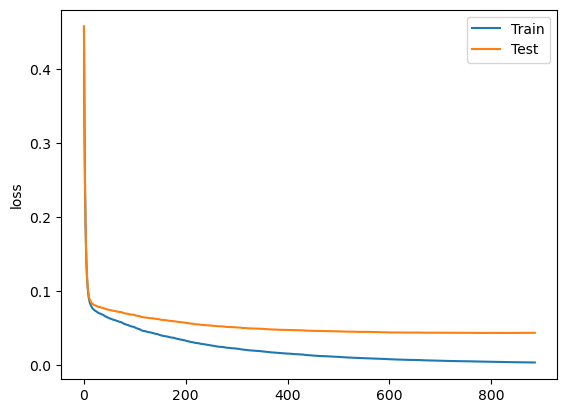

In [35]:
x_axis = range(0, len(evals_result["train"]["mlogloss"]))
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result["train"]["mlogloss"], label='Train')
ax.plot(x_axis, evals_result["validation"]["mlogloss"], label='Test')
ax.legend()
plt.ylabel('loss')
plt.show()

We see that the model performs better than the model trained with sklearn, gaining a higher F1 score (0.58 vs 0.44).

In [36]:
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
np.set_printoptions(suppress=True)

# pos_label=1 (the default) is correct for us.
print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(f"recall: {recall_score(test_labels, preds)}")
print(f"balanced accuracy: {balanced_accuracy_score(test_labels, preds)}")
print(f"f1 score: {f1_score(test_labels, preds)}")
print(f"confusion matrix (non-normalized):\n {confusion_matrix(test_labels, preds, normalize=None)}")
print(f"confusion matrix (normalized over true classes/rows):\n {confusion_matrix(test_labels, preds, normalize='true')}")

print(classification_report(test_labels, preds, target_names=["no sepsis", "sepsis"]))

accuracy: 0.9866517509136742
recall: 0.41857241857241856
balanced accuracy: 0.7089756904610055
f1 score: 0.57882127455678
confusion matrix (non-normalized):
 [[193105    120]
 [  2517   1812]]
confusion matrix (normalized over true classes/rows):
 [[0.99937896 0.00062104]
 [0.58142758 0.41857242]]
              precision    recall  f1-score   support

   no sepsis       0.99      1.00      0.99    193225
      sepsis       0.94      0.42      0.58      4329

    accuracy                           0.99    197554
   macro avg       0.96      0.71      0.79    197554
weighted avg       0.99      0.99      0.98    197554



Variable importances are computed during model fitting and can be retrieved quickly. Computing those in sklearn takes hours.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

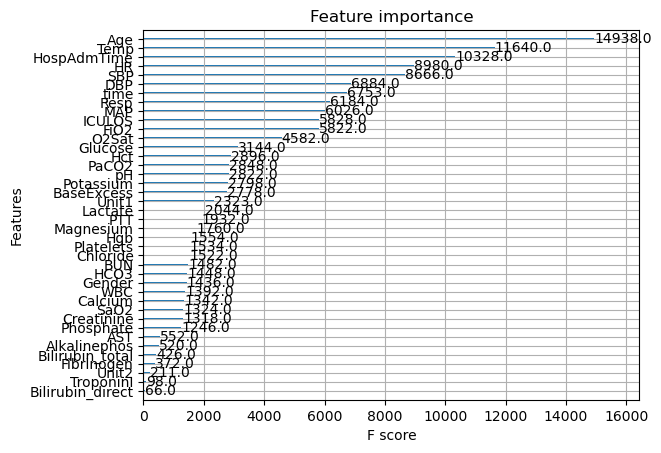

In [37]:
from xgboost import plot_importance
plot_importance(model)

## Accounting for imbalanced data

Both scikit and xgboost can be configured to respect class weights. We choose those to be inversely proportional to the class count. That way, the data points of septic patients are much more influential in training.

Again, scikit is easier to write but xgboost gives the better results.

Where the models before were heavily skewed towards great precision but bad recall, we now see inversed results.
While the sklearn model is heavily skewed towards recall but lacks precision, the xgboost model appears to be the most rounded and versatile model, featuring mediocre precision and recall but overall earing the hightest f1 score.

In [ ]:
# balance the data (sklearn)
rf_bal = HistGradientBoostingClassifier(verbose=1, max_depth=10, max_iter=1500, random_state = 43, tol=1e-3, class_weight="balanced")
est_bal = rf.fit(train_features, train_labels)
preds_bal_sklearn = est_bal.predict(test_features)


# balance the data (XGBoost)

negative_instances = (train_labels == 0).sum()
positive_instances = (train_labels == 1).sum()
# see https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost
ratio = np.sqrt(negative_instances/positive_instances)
sample_weight_train = compute_sample_weight({0: 1.0, 1: ratio}, train_labels)
sample_weight_test = compute_sample_weight({0: 1.0, 1: ratio}, test_labels)

dtrain_clf_bal = xgb.DMatrix(train_features, train_labels, feature_names=ref_df_names, enable_categorical=True, weight=sample_weight_train)
dtest_clf_bal = xgb.DMatrix(test_features, test_labels, feature_names=ref_df_names, enable_categorical=True, weight=sample_weight_test)

evals_bal = [(dtrain_clf, "train"), (dtest_clf, "validation")]

# account for different weights: https://github.com/dmlc/xgboost/issues/8184
# setting class_weight or scale_pos_weight is not applicable here (API incompability), we have to go with the weights directly
# in the matrices.
# Invoking xgboost via the scikit API (where class weights can be set directly) suffered from very low performance for me.
model_bal = xgb.train(
   params=params,
   dtrain=dtrain_clf_bal,
   num_boost_round=n,
   evals=evals_bal,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50, # Activate early stopping
)

preds_bal_xgboost = model_bal.predict(dtest_clf_bal)

In [ ]:
print(classification_report(test_labels, preds_bal_sklearn, target_names=["no sepsis", "sepsis"]))
print(classification_report(test_labels, preds_bal_xgboost, target_names=["no sepsis", "sepsis"]))

In [41]:
# idea for further research:
# Reimplement CaptureStatistics from "a study of kNN using ICU multivariate data"

# 1) z-score normalization
# 2) find min, max, mean, moving average for each (multivariate) time series
# 3) find min, max, mean, moving average for Q (the time series that should be classified).
# 4) find k nearest neighbors using kNN
# 5) apply majority vote, classify Q.

## Filtering and Interpolation

Following the analysis of feature contribution and the initial interpolation of missing values, we will select the most important features to predict sepsis. Also, since the LSTM requires a data set without missing values, we will impute all remaining missing values.

In [42]:
from sklearn.feature_selection import SelectFromModel

For prediction, we will use all features except the 10 least important features.

In [43]:
# Get n most important features
feature_names = model.feature_names

# Get the feature importance dictionary
feature_importance = model.get_score(importance_type="gain")

# Sort the feature importance in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get the top N most important features
top_n_features = sorted_feature_importance[:-10]  # N=-10; Replace with the desired number of features
to_drop_features = sorted_feature_importance[-10:]

# Get the actual feature names of the top features
top_feature_names = [feature for feature, _ in top_n_features]
to_drop_feature_names = [feature for feature, _ in to_drop_features]

In [44]:
# Features that will be kept
top_feature_names

['Unit2',
 'ICULOS',
 'Bilirubin_direct',
 'Fibrinogen',
 'FiO2',
 'Bilirubin_total',
 'Unit1',
 'AST',
 'Alkalinephos',
 'Lactate',
 'HospAdmTime',
 'Age',
 'TroponinI',
 'WBC',
 'Gender',
 'Creatinine',
 'Calcium',
 'Platelets',
 'PTT',
 'SaO2',
 'Magnesium',
 'HCO3',
 'time',
 'BaseExcess',
 'PaCO2',
 'Phosphate',
 'Chloride',
 'Hct',
 'BUN',
 'Temp']

In [45]:
# Features that will be droped
to_drop_feature_names

['pH',
 'Resp',
 'Hgb',
 'Potassium',
 'Glucose',
 'DBP',
 'HR',
 'SBP',
 'O2Sat',
 'MAP']

In [46]:
# Select subsample of data frame
red_df = ref_df.drop(to_drop_feature_names, axis=1)


In [47]:
red_df.head()

,time,Temp,EtCO2,BaseExcess,HCO3,FiO2,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Lactate,Magnesium,Phosphate,Bilirubin_total,TroponinI,Hct,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,0
3,3,NaN,NaN,24.000000,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,0
4,4,NaN,NaN,23.857143,NaN,0.28,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,0


In [48]:
# Display amount of remaining missing values
value_availability = red_df.count().sort_values()/red_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.004829
Bilirubin_direct    0.005061
Fibrinogen          0.025098
Bilirubin_total     0.048599
Alkalinephos        0.050533
AST                 0.051829
Lactate             0.099187
SaO2                0.135931
PTT                 0.186897
Calcium             0.195952
Phosphate           0.198807
Platelets           0.252148
WBC                 0.255000
Creatinine          0.260700
PaCO2               0.263378
Magnesium           0.266598
BaseExcess          0.274619
HCO3                0.274737
BUN                 0.278744
Chloride            0.281659
Hct                 0.379570
FiO2                0.382857
Unit2               0.530462
Unit1               0.530462
Temp                0.859199
HospAdmTime         0.999994
ICULOS              1.000000
time                1.000000
Age                 1.000000
SepsisLabel         1.000000
Gender              1.000000
patient_id          1.000000
dtype: float64

Several columns still have a massiv amount of missing data, i.e. less than 10% available data. Susequently, all columns with less than 10% overall data will be dropped.

In [49]:
threshold = 0.90  # Set the threshold for missing data

# Calculate the number of non-null values in each column
non_null_counts = red_df.notnull().sum()

# Calculate the percentage of missing full_df in each column
missing_percentages = 1 - (non_null_counts / len(red_df))

# Identify columns with missing data exceeding the threshold
columns_to_drop = missing_percentages[missing_percentages > threshold].index

# Drop columns with excessive missing data
red_df = red_df.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
print("Dropped columns (less that 10% availble data):", columns_to_drop)

Dropped columns (less that 10% availble data): Index(['EtCO2', 'AST', 'Alkalinephos', 'Bilirubin_direct', 'Lactate',
       'Bilirubin_total', 'TroponinI', 'Fibrinogen'],
      dtype='object')


Interpolate remaining missing data.

In [50]:
# Forward- and backward fill missing values at the start of each patient's data
red_df_filled = red_df.groupby('patient_id', group_keys=False).apply(lambda group: group.ffill())
red_df_filled = red_df_filled.groupby('patient_id', group_keys=False).apply(lambda group: group.bfill())

In [51]:
# Interpolate missing values within each patient's data using linear interpolation
df_int = red_df_filled.groupby('patient_id', group_keys=False).apply(lambda x: x.interpolate(method='linear'))

In [52]:
df_int.head()

,time,Temp,BaseExcess,HCO3,FiO2,PaCO2,SaO2,BUN,Calcium,Chloride,Creatinine,Magnesium,Phosphate,Hct,PTT,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,NaN,5.7,317.0,83.14,0,NaN,NaN,-0.03,1,0,0
1,1,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,NaN,5.7,317.0,83.14,0,NaN,NaN,-0.03,2,0,0
2,2,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,NaN,5.7,317.0,83.14,0,NaN,NaN,-0.03,3,0,0
3,3,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,NaN,5.7,317.0,83.14,0,NaN,NaN,-0.03,4,0,0
4,4,36.11,23.857143,45.0,0.28,98.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,NaN,5.7,317.0,83.14,0,NaN,NaN,-0.03,5,0,0


For patients with completely missing variables, fill missing values with variable mean over all available patients.

In [53]:
vars = df_int.columns
# Calculate the mean for the variables over all patients
mean_values = df_int[vars].mean()

# Iterate over the variables and fill missing values with the corresponding mean
for variable in vars:
    df_int[variable] = df_int[variable].fillna(mean_values[variable])

In [54]:
df_int.head()

,time,Temp,BaseExcess,HCO3,FiO2,PaCO2,SaO2,BUN,Calcium,Chloride,Creatinine,Magnesium,Phosphate,Hct,PTT,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,1,0,0
1,1,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,2,0,0
2,2,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,3,0,0
3,3,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,4,0,0
4,4,36.11,23.857143,45.0,0.28,98.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,5,0,0


In [55]:
# Check for remaining missing values
df_int.isnull().values.any()

False

In [56]:
top_feature_names

['Unit2',
 'ICULOS',
 'Bilirubin_direct',
 'Fibrinogen',
 'FiO2',
 'Bilirubin_total',
 'Unit1',
 'AST',
 'Alkalinephos',
 'Lactate',
 'HospAdmTime',
 'Age',
 'TroponinI',
 'WBC',
 'Gender',
 'Creatinine',
 'Calcium',
 'Platelets',
 'PTT',
 'SaO2',
 'Magnesium',
 'HCO3',
 'time',
 'BaseExcess',
 'PaCO2',
 'Phosphate',
 'Chloride',
 'Hct',
 'BUN',
 'Temp']

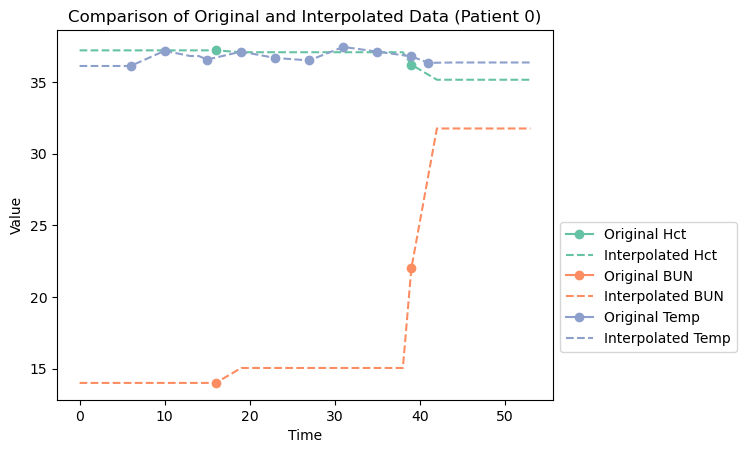

In [57]:
# Example plot of interpolated data
# Choose a specific patient for plotting (e.g., patient_id = 0)/975
patient_id = 0

# Specify the columns to plot
columns_to_plot = top_feature_names[-3:]

# Generate a color palette based on the number of variables
color_palette = sns.color_palette('Set2', len(columns_to_plot))

# Filter the original and interpolated data for the selected patient
original_patient_data = full_df[full_df['patient_id'] == patient_id]
interpolated_patient_data = df_int[df_int['patient_id'] == patient_id]

# Set up the figure and subplot
fig, ax = plt.subplots()

# Iterate over the columns and plot the original and interpolated data
for variable, color in zip(columns_to_plot, color_palette):
    # Plot the original data
    ax.plot(original_patient_data['time'], original_patient_data[variable], label=f'Original {variable}', marker="o", color=color)

    # Plot the interpolated data
    ax.plot(interpolated_patient_data['time'], interpolated_patient_data[variable], label=f'Interpolated {variable}', linestyle='--', color=color)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title(f'Comparison of Original and Interpolated Data (Patient {patient_id})')

# Add legend
ax.legend(bbox_to_anchor=(1, 0.5), loc="upper left")

# Show the plot
plt.show()

## Time Series Prediction Models

### Create test and train set

In [58]:
unique_patients = df_int['patient_id'].unique()

# Split the patients into train and test sets
train_patients, test_patients = train_test_split(unique_patients, test_size=0.1, random_state=42)

# Filter the data based on the train and test patients
train_data = df_int[df_int['patient_id'].isin(train_patients)]
test_data = df_int[df_int['patient_id'].isin(test_patients)]

In [59]:
len(unique_patients)

20336

In [60]:
train_data.shape

(710284, 25)

In [61]:
test_data.shape

(79931, 25)

Check for remaining missing data.

In [62]:
train_data.isnull().values.any()

False

In [63]:
test_data.isnull().values.any()

False

Scale the features using MinMaxScaler.

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

Prepare feature selection.

In [65]:
features = train_data.loc[:,train_data.columns!="SepsisLabel"].columns

n_features = len(features)-1

In [66]:
train_data.head()

,time,Temp,BaseExcess,HCO3,FiO2,PaCO2,SaO2,BUN,Calcium,Chloride,Creatinine,Magnesium,Phosphate,Hct,PTT,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,1,0,0
1,1,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,2,0,0
2,2,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,3,0,0
3,3,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,4,0,0
4,4,36.11,23.857143,45.0,0.28,98.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,5,0,0


### LSTM

In [67]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

#### Window Size 5

In [68]:
window_size = 5

# Define a function to create sliding windows for each patient
def create_sliding_windows(data):
    """
    Creates sliding windows of a specified size from the given data.

    Args:
        data (pandas.DataFrame): The input data from which sliding windows are created.

    Returns:
        list: A list of sliding windows, where each window is a subset of the input data.

    """
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    return windows

In [69]:
# Create sliding windows for each patient in the training data
train_windows = train_data.groupby('patient_id').apply(create_sliding_windows)

In [70]:
train_data.head()

,time,Temp,BaseExcess,HCO3,FiO2,PaCO2,SaO2,BUN,Calcium,Chloride,Creatinine,Magnesium,Phosphate,Hct,PTT,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,1,0,0
1,1,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,2,0,0
2,2,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,3,0,0
3,3,36.11,24.000000,45.0,0.28,100.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,4,0,0
4,4,36.11,23.857143,45.0,0.28,98.0,88.0,14.0,9.3,85.0,0.7,2.0,3.3,37.2,36.474872,5.7,317.0,83.14,0,0.502394,0.497606,-0.03,5,0,0


In [71]:
# Prepare training data
train_X = np.empty((0, window_size-1, n_features)) #
train_y = np.empty((0,))
for windows, patient_data in zip(train_windows, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :-1, :n_features]
    y = np.stack(windows)[:, -1, -2]
    train_X = np.concatenate((train_X, X))
    train_y = np.concatenate((train_y, y))

In [72]:
train_y

array([0., 0., 0., ..., 1., 1., 1.])

In [73]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y), y=train_y)
class_weights_array

array([ 0.5116542 , 21.95148508])

In [74]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array  ))
class_weights

{0: 0.51165420478183, 1: 21.951485080283923}

In [75]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size-1, n_features)))
model.add(Dense(1, activation='sigmoid'))

In [76]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [77]:
# Train the model
model.fit(train_X, train_y, epochs=21, batch_size=32, class_weight=class_weights)

Epoch 1/21
19909/19909 [==============================] - 97s 5ms/step - loss: 0.6137
Epoch 2/21
19909/19909 [==============================] - 94s 5ms/step - loss: 0.5989
Epoch 3/21
19909/19909 [==============================] - 95s 5ms/step - loss: 0.5990
Epoch 4/21
19909/19909 [==============================] - 95s 5ms/step - loss: 0.5927
Epoch 5/21
19909/19909 [==============================] - 95s 5ms/step - loss: 0.5879
Epoch 6/21
19909/19909 [==============================] - 97s 5ms/step - loss: 0.5893
Epoch 7/21
19909/19909 [==============================] - 97s 5ms/step - loss: 0.5874
Epoch 8/21
19909/19909 [==============================] - 97s 5ms/step - loss: 0.5868
Epoch 9/21
19909/19909 [==============================] - 97s 5ms/step - loss: 0.5859
Epoch 10/21
19909/19909 [==============================] - 95s 5ms/step - loss: 0.5864
Epoch 11/21
19909/19909 [==============================] - 95s 5ms/step - loss: 0.5865
Epoch 12/21
19909/19909 [===========================

In [78]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [79]:
# Prepare test data
test_X = np.empty((0, window_size-1, n_features))
test_y_true = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :-1, :n_features]
    y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the second last column
    test_X = np.concatenate((test_X, X))
    test_y_true = np.concatenate((test_y_true, y_true))

In [80]:
test_y_true

array([0., 0., 0., ..., 0., 0., 0.])

In [81]:
sum(test_y_true)/len(test_y_true)

0.02157531861550247

In [82]:
# Make predictions on the test data
test_y_pred = model.predict(test_X)

# Convert predictions to binary values
test_y_pred = (test_y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(test_y_true, test_y_pred)
precision = precision_score(test_y_true, test_y_pred)
recall = recall_score(test_y_true, test_y_pred)
auc_roc = roc_auc_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC Score:", auc_roc)

2244/2244 [==============================] - 6s 2ms/step
Accuracy: 0.894909116233721
Precision: 0.0772701635645798
Recall: 0.3537766300839251
AUC-ROC Score: 0.6303091503920181


2244/2244 [==============================] - 5s 2ms/step


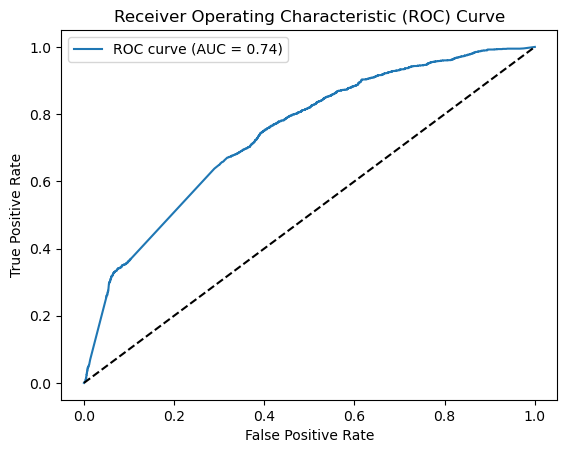

In [83]:
# Compute the predicted probabilities for the positive class
test_y_pred_prob = model.predict(test_X)

# Compute the AUC-ROC score
auc_roc = roc_auc_score(test_y_true, test_y_pred_prob)

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(test_y_true, test_y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Create table for results comparison.

In [84]:
# Define the window sizes
window_sizes = [5, 10]

In [85]:
# Initialize the table to store the results
results_table = pd.DataFrame(columns=['Window Size', 'Accuracy', 'Precision', 'Recall', 'AUROC'])

In [86]:
# Add the results to the table
results_table = results_table.append({
        'Window Size': window_sizes[0],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUROC': auc_roc
    }, ignore_index=True)

C:\Users\dorot\AppData\Local\Temp\ipykernel_5488\2999737253.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


#### Window Size 10

In [87]:
window_size = 10

In [88]:
# Create sliding windows for each patient in the training data
train_windows_10 = train_data.groupby('patient_id').apply(create_sliding_windows)

In [89]:
# Prepare training data
train_X_10 = np.empty((0, window_size-1, n_features)) #
train_y_10 = np.empty((0,))
for windows, patient_data in zip(train_windows_10, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    if len(scaled_data) > 10:
        X = np.stack(windows)[:, :-1, :n_features]
        y = np.stack(windows)[:, -1, -2]
        train_X_10 = np.concatenate((train_X_10, X))
        train_y_10 = np.concatenate((train_y_10, y))

In [90]:
train_y_10

array([0., 0., 0., ..., 1., 1., 1.])

In [91]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y_10), y=train_y_10)
class_weights_array

array([ 0.51183174, 21.62959879])

In [92]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array))
class_weights

{0: 0.5118317438219196, 1: 21.629598794798603}

In [93]:
# Define the LSTM model architecture
model_10 = Sequential()
model_10.add(LSTM(50, input_shape=(window_size-1, n_features)))
model_10.add(Dense(1, activation='sigmoid'))

In [94]:
# Compile the model
model_10.compile(loss='binary_crossentropy', optimizer='adam')

In [95]:
# Train the model
model_10.fit(train_X_10, train_y_10, epochs=21, batch_size=32, class_weight=class_weights)

Epoch 1/21
17050/17050 [==============================] - 122s 7ms/step - loss: 0.5993
Epoch 2/21
17050/17050 [==============================] - 122s 7ms/step - loss: 0.5881
Epoch 3/21
17050/17050 [==============================] - 122s 7ms/step - loss: 0.5860
Epoch 4/21
17050/17050 [==============================] - 123s 7ms/step - loss: 0.5850
Epoch 5/21
17050/17050 [==============================] - 124s 7ms/step - loss: 0.5845
Epoch 6/21
17050/17050 [==============================] - 121s 7ms/step - loss: 0.5836
Epoch 7/21
17050/17050 [==============================] - 122s 7ms/step - loss: 0.5834
Epoch 8/21
17050/17050 [==============================] - 122s 7ms/step - loss: 0.5838
Epoch 9/21
17050/17050 [==============================] - 122s 7ms/step - loss: 0.5842
Epoch 10/21
17050/17050 [==============================] - 123s 7ms/step - loss: 0.5821
Epoch 11/21
17050/17050 [==============================] - 121s 7ms/step - loss: 0.5808
Epoch 12/21
17050/17050 [================

In [96]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [97]:
# Prepare test data
test_X_10 = np.empty((0, window_size-1, n_features))
test_y_true_10 = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    if len(scaled_data) > 10:
        X = np.stack(windows)[:, :-1, :n_features]
        y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the second last column
        test_X_10 = np.concatenate((test_X_10, X))
        test_y_true_10 = np.concatenate((test_y_true_10, y_true))

In [98]:
test_y_true_10

array([0., 0., 0., ..., 0., 0., 0.])

In [99]:
sum(test_y_true_10)/len(test_y_true_10)

0.02092966658554393

In [100]:
# Make predictions on the test data
test_y_pred_10 = model_10.predict(test_X_10)

# Convert predictions to binary values
test_y_pred_10 = (test_y_pred_10 > 0.5).astype(int)

# Evaluate the model
accuracy_10 = accuracy_score(test_y_true_10, test_y_pred_10)
precision_10 = precision_score(test_y_true_10, test_y_pred_10)
recall_10 = recall_score(test_y_true_10, test_y_pred_10)
auc_roc_10 = roc_auc_score(test_y_true_10, test_y_pred_10)

# Print evaluation metrics
print("Accuracy:", accuracy_10)
print("Precision:", precision_10)
print("Recall:", recall_10)
print("AUC-ROC Score:", auc_roc_10)

1927/1927 [==============================] - 8s 4ms/step
Accuracy: 0.7439766366512534
Precision: 0.04599573881438777
Recall: 0.5689922480620155
AUC-ROC Score: 0.6583547701491618


1927/1927 [==============================] - 8s 4ms/step


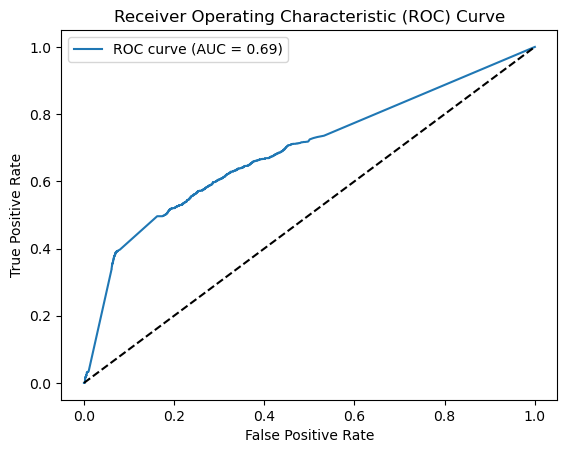

In [101]:
# Compute the predicted probabilities for the positive class
test_y_pred_prob_10 = model_10.predict(test_X_10)

# Compute the AUC-ROC score
auc_roc_10 = roc_auc_score(test_y_true_10, test_y_pred_prob_10)

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(test_y_true_10, test_y_pred_prob_10)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc_10))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [102]:
# Add the results to the table
results_table = results_table.append({
        'Window Size': window_sizes[1],
        'Accuracy': accuracy_10,
        'Precision': precision_10,
        'Recall': recall_10,
        'AUROC': auc_roc_10
    }, ignore_index=True)

C:\Users\dorot\AppData\Local\Temp\ipykernel_5488\1007679854.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


#### Compare Model Results

In [103]:
# Print the results table
print(results_table)

   Window Size  Accuracy  Precision    Recall     AUROC
0          5.0  0.894909   0.077270  0.353777  0.741402
1         10.0  0.743977   0.045996  0.568992  0.692168


## Open Questions and To Dos

*   Compare different feature selection sets
*   Predict further than one time step (= hour) into future (n-steps ahead)
*   Apply additional prediction models and compare results


